In [62]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from individual import Tree
import protectedOperators

In [63]:
NUM_ISLANDS = 7
ISLAND_SIZE = 118
GENERATIONS = 1000
MAX_DEPTH = 11
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 150
MIGRATION_SIZE = 4
PRINT_INTERVAL = 100
TREE_ATTEMPTS = 10
TEST_TRAIN = 0.7
STAGNATION_THRESHOLD = 60

POPULATION_SIZE = ISLAND_SIZE * NUM_ISLANDS

In [64]:
def plot_fitness_trend(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    #plt.show()

def plot_predictions(y_test, y_pred, fitness):
    # Defensive: handle empty or 0-dim y_pred
    if y_pred is None or np.size(y_pred) == 0:
        print("[WARNING] y_pred is empty or None. Skipping prediction plot.")
        plt.figure(figsize=(10, 5))
        plt.title("Prediction plot unavailable: y_pred is empty.")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.grid()
        return
    sorted_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Actual vs Predicted - Fitness: {fitness:.4f}")
    plt.legend()
    plt.grid()
    #plt.show()

In [65]:
class SymbolicRegressionGP:
    def __init__(self, x_train, y_train,
                 num_islands=NUM_ISLANDS, island_size=ISLAND_SIZE, generations=GENERATIONS,
                 max_depth=MAX_DEPTH, mutation_rate=MUTATION_RATE, tournament_size=TOURNAMENT_SIZE,
                 migration_interval=MIGRATION_INTERVAL, migration_size=MIGRATION_SIZE,
                 print_interval=PRINT_INTERVAL, tree_attempts=TREE_ATTEMPTS,
                 stagnation_threshold=STAGNATION_THRESHOLD):
        self.x_train = x_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.island_size = island_size
        self.generations = generations
        self.max_depth = max_depth
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.print_interval = print_interval
        self.tree_attempts = tree_attempts
        self.stagnation_threshold = stagnation_threshold
        self.populations = []

    def initialize_population(self):
        self.populations = []
        for _ in range(self.num_islands):
            island = []
            while len(island) < self.island_size:
                t = Tree(self.max_depth, self.x_train, self.y_train, self.tree_attempts)
                t.populate()
                if np.isfinite(t.fitness):
                    island.append(t)
            self.populations.append(island)

    def tournament_selection(self, population):
        tournament_size = min(self.tournament_size, len(population))
        participants = random.sample(population, tournament_size)
        participants.sort(key=lambda t: t.fitness)
        weights = [tournament_size - i for i in range(tournament_size)]
        return random.choices(participants, weights=weights, k=1)[0]

    def migrate(self):
        for i in range(self.num_islands):
            source = self.populations[i]
            target_index = (i + 1) % self.num_islands
            target = self.populations[target_index]
            migrants = sorted(source, key=lambda t: t.fitness)[:self.migration_size]
            target_sorted = sorted(target, key=lambda t: t.fitness, reverse=True)
            for j in range(self.migration_size):
                if migrants[j].fitness < target_sorted[j].fitness:
                    idx = target.index(target_sorted[j])
                    target[idx] = migrants[j].clone_tree()
            self.populations[target_index] = target

    def extinction(self, extinction_fraction=0.2):
        for i in range(self.num_islands):
            self.populations[i] = sorted(self.populations[i], key=lambda t: t.fitness)
            num_extinct = int(self.island_size * extinction_fraction)
            survivors = self.populations[i][:self.island_size - num_extinct]
            new_individuals = []
            for _ in range(num_extinct):
                t = Tree(self.max_depth, self.x_train, self.y_train, self.tree_attempts)
                t.populate()
                if np.isfinite(t.fitness):
                    new_individuals.append(t)
            self.populations[i] = survivors + new_individuals

    def run(self, stagnation_threshold=72):
        self.initialize_population()
        best_tree = None
        best_fitness = np.inf
        fitness_history = []
        stagnation_cnt = 0

        for gen in tqdm(range(self.generations), desc="Generations"):
            for idx in range(self.num_islands):
                current_pop = self.populations[idx]
                new_pop = []
                elite = min(current_pop, key=lambda t: t.fitness)
                new_pop.append(elite.clone_tree())
                while len(new_pop) < self.island_size:
                    if random.random() < self.mutation_rate:
                        parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        p1 = self.tournament_selection(current_pop)
                        p2 = self.tournament_selection(current_pop)
                        c1, c2 = p1.recombine(p2)
                        new_pop.extend([c1, c2])
                self.populations[idx] = sorted(current_pop + new_pop, key=lambda t: t.fitness)[:self.island_size]

            if (gen + 1) % self.migration_interval == 0:
                self.migrate()

            improve = False
            for pop in self.populations:
                best_island = min(pop, key=lambda t: t.fitness)
                if best_island.fitness < best_fitness:
                    best_fitness = best_island.fitness
                    best_tree = best_island.clone_tree()
                    improve = True

            fitness_history.append(best_fitness)

            if improve:
                stagnation_cnt = 0
            else:
                stagnation_cnt += 1

            if stagnation_cnt >= stagnation_threshold:
                print(f"Gen {gen+1} Stagnation detected")
                self.extinction()
                stagnation_cnt = 0

            if (gen + 1) % self.print_interval == 0:
                print(f"Gen {gen+1} Best fitness: {best_fitness} Formula: {best_tree}")

        return best_tree, fitness_history

In [66]:
class SymbolicRegressionMC:
    def __init__(self, x_train, y_train,
                 population_size=POPULATION_SIZE,
                 generations=GENERATIONS,
                 max_depth=MAX_DEPTH,
                 tree_attempts=TREE_ATTEMPTS,
                 tournament_size=TOURNAMENT_SIZE,
                 num_islands=NUM_ISLANDS,
                 mutation_rate=MUTATION_RATE,
                 migration_interval=MIGRATION_INTERVAL,
                 migration_size=MIGRATION_SIZE,
                 stagnation_threshold=STAGNATION_THRESHOLD,
                 print_interval=PRINT_INTERVAL,
                 refresh_fraction=0.2,
                 mc_bias_prob=0.6,
                 penalty_lambda=1e-3,
                 max_nodes=250,
                 early_stop_patience=None):
        # Data / hyperparams
        self.x_train = x_train
        self.y_train = y_train
        self.population_size = population_size
        self.generations = generations
        self.max_depth = max_depth
        self.tree_attempts = tree_attempts
        self.tournament_size = tournament_size
        self.print_interval = print_interval

        # GP / island params
        self.num_islands = num_islands
        self.island_size = max(2, self.population_size // max(1, self.num_islands))
        self.mutation_rate = mutation_rate
        self.migration_interval = migration_interval
        self.migration_size = migration_size

        # Monte Carlo / stagnation
        self.stagnation_threshold = stagnation_threshold
        self.refresh_fraction = refresh_fraction
        self.mc_bias_prob = mc_bias_prob  # bias toward mutating elites

        # Other controls
        self.penalty_lambda = penalty_lambda   # complexity penalty factor
        self.MAX_NODES = max_nodes             # bloat control on recombined children
        self.early_stop_patience = early_stop_patience or int(self.generations * 0.25)

        # internals
        self.populations = []  # list of islands: each is list of Tree
        self.best_tree = None
        self.best_fitness = float('inf')  # penalized fitness tracked
        self.fitness_history = []

    # ---------------------------
    # Initialization / helpers
    # ---------------------------
    def initialize_population(self):
        """Initialize islands with random trees (valid fitness only)."""
        self.populations = []
        for _ in range(self.num_islands):
            island = []
            while len(island) < self.island_size:
                t = Tree(self.max_depth, self.x_train, self.y_train, self.tree_attempts)
                t.populate()
                # rely on existing Tree to set t.fitness during populate()
                if np.isfinite(t.fitness):
                    island.append(t)
            # sort by penalized fitness once computed (we'll compute below)
            self.populations.append(island)

    def _compute_penalized_fitness_for_population(self, pop):
        """Compute and attach _pf (penalized fitness) attribute to each tree for selection/sorting."""
        for t in pop:
            try:
                size = t.size()
            except Exception:
                size = 0
            t._pf = t.fitness + self.penalty_lambda * size
        return

    def _clear_penalized_marks(self, pop):
        for t in pop:
            if hasattr(t, "_pf"):
                del t._pf

    # ---------------------------
    # Selection primitives
    # ---------------------------
    def tournament_selection(self, population, k=None):
        k = k or self.tournament_size
        k = min(k, len(population))
        participants = random.sample(population, k)
        # use penalized fitness if present
        participants.sort(key=lambda t: getattr(t, "_pf", t.fitness))
        # weighted choice to prefer better ones
        weights = [k - i for i in range(k)]
        return random.choices(participants, weights=weights, k=1)[0]

    def monte_carlo_parent(self, population, temperature, sample_k=3):
        """
        Monte Carlo selection with normalized fitness within the sample.
        Uses penalized fitness (_pf) if available.
        """
        if temperature <= 0:
            return min(population, key=lambda t: getattr(t, "_pf", t.fitness))

        sample_k = min(sample_k, len(population))
        sample = random.sample(population, sample_k)

        # collect penalized fitnesses
        fits = np.array([getattr(t, "_pf", t.fitness) for t in sample], dtype=float)
        # normalize to [0,1] where 0 = best
        minf, maxf = fits.min(), fits.max()
        span = (maxf - minf) if maxf > minf else 1.0
        norm = (fits - minf) / span

        # candidate and reference
        idx_cand = random.randrange(len(sample))
        cand = sample[idx_cand]
        idx_ref = int(np.argmin(norm))
        ref = sample[idx_ref]

        delta = norm[idx_cand] - norm[idx_ref]  # >=0
        if delta <= 0:
            return cand
        # acceptance probability (temperature on normalized scale)
        try:
            acceptance = np.exp(-delta / temperature)
        except OverflowError:
            acceptance = 0.0
        if random.random() < acceptance:
            return cand
        return ref

    # ---------------------------
    # Migration & refresh
    # ---------------------------
    def migrate(self):
        """Mix elites + innovators into neighbor islands. Randomize direction sometimes."""
        for i in range(self.num_islands):
            source = self.populations[i]
            # choose direction with small probability reversed
            if random.random() < 0.25:
                target_idx = (i - 1) % self.num_islands
            else:
                target_idx = (i + 1) % self.num_islands
            target = self.populations[target_idx]

            source_sorted = sorted(source, key=lambda t: getattr(t, "_pf", t.fitness))
            # take top half migrants from elites and some random innovators
            num_elite = max(1, self.migration_size // 2)
            num_rand = self.migration_size - num_elite
            elites = source_sorted[:num_elite]
            innovators = random.sample(source, min(num_rand, len(source)))
            migrants = elites + innovators

            # replace worst in target if migrants are better
            worst_in_target = sorted(target, key=lambda t: getattr(t, "_pf", t.fitness), reverse=True)
            for m, w in zip(migrants, worst_in_target):
                if getattr(m, "_pf", m.fitness) < getattr(w, "_pf", w.fitness):
                    idx = target.index(w)
                    target[idx] = m.clone_tree()
            self.populations[target_idx] = target

    def mc_refresh(self, island, dynamic_fraction):
        """
        Replace worst fraction of island with biased new individuals.
        dynamic_fraction: fraction to replace in [0,1]
        """
        island.sort(key=lambda t: getattr(t, "_pf", t.fitness))
        num_replace = int(len(island) * dynamic_fraction)
        if num_replace <= 0:
            return island
        survivors = island[:-num_replace]
        new_individuals = []

        attempts = 0
        while len(new_individuals) < num_replace and attempts < max(500, num_replace * 10):
            attempts += 1
            if random.random() < self.mc_bias_prob and len(survivors) > 0:
                # Bias: pick a good donor from top quartile, mutate it
                donor_pool = survivors[:max(1, len(survivors)//4)]
                donor = random.choice(donor_pool).clone_tree()
                donor.mutate()
                if np.isfinite(donor.fitness):
                    new_individuals.append(donor)
            else:
                t = Tree(self.max_depth, self.x_train, self.y_train, self.tree_attempts)
                t.populate()
                if np.isfinite(t.fitness):
                    new_individuals.append(t)

        # If still short, fill by mutating survivors
        while len(new_individuals) < num_replace:
            donor = random.choice(survivors).clone_tree()
            donor.mutate()
            new_individuals.append(donor)

        new_island = survivors + new_individuals
        return new_island

    # ---------------------------
    # Main evolution loop
    # ---------------------------
    def evolve(self):
        self.initialize_population()
        stagnation_count = 0
        island_stagnation = [0] * self.num_islands  # track stagnation per island

        # Temperature / mutation
        T0 = 1.0
        T_min = 0.01
        temp_decay = 0.98
        mutation_rate = 0.5
        min_mutation_rate = 0.2
        mutation_decay = 0.995

        penalty_lambda = 0.002  # stronger size penalty than before
        temperature = T0

        for gen in tqdm(range(self.generations), desc="Generations"):
            for idx in range(self.num_islands):
                current_pop = self.populations[idx]

                # Recalculate fitness with size penalty
                for t in current_pop:
                    t.fitness = t.fitness + penalty_lambda * t.size()

                new_pop = []
                elite = min(current_pop, key=lambda t: t.fitness)
                new_pop.append(elite.clone_tree())

                # Determine MC usage for this island
                mc_prob = max(0.05, 0.5 * (1 - gen / (self.generations * 0.7)))
                # Boost MC usage only if stagnating
                if island_stagnation[idx] > self.stagnation_threshold // 3:
                    mc_prob *= 2.0  # exploration boost

                while len(new_pop) < self.island_size:
                    if random.random() < mutation_rate:
                        if random.random() < mc_prob:
                            parent = self.monte_carlo_parent(current_pop, temperature, sample_k=4)
                        else:
                            parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        if random.random() < mc_prob:
                            p1 = self.monte_carlo_parent(current_pop, temperature, sample_k=4)
                            p2 = self.monte_carlo_parent(current_pop, temperature, sample_k=4)
                        else:
                            p1 = self.tournament_selection(current_pop)
                            p2 = self.tournament_selection(current_pop)
                        if p1 is p2:
                            p2 = random.choice(current_pop)
                        c1, c2 = p1.recombine(p2)
                        new_pop.extend([c1, c2])

                combined = current_pop + new_pop
                combined.sort(key=lambda t: t.fitness)
                best_before = current_pop[0].fitness
                self.populations[idx] = combined[:self.island_size]

                # Track stagnation per island
                if self.populations[idx][0].fitness < best_before:
                    island_stagnation[idx] = 0
                else:
                    island_stagnation[idx] += 1

            # Migration
            if (gen + 1) % 100 == 0:
                self.migrate()

            # Global best
            improve = False
            for island in self.populations:
                best_island = min(island, key=lambda t: t.fitness)
                if best_island.fitness < self.best_fitness:
                    self.best_fitness = best_island.fitness
                    self.best_tree = best_island.clone_tree()
                    improve = True

            self.fitness_history.append(self.best_fitness)

            if improve:
                stagnation_count = 0
            else:
                stagnation_count += 1

            # If full stagnation, refresh & reheat
            if stagnation_count >= self.stagnation_threshold:
                print(f"Gen {gen+1} - Full stagnation: refreshing islands and reheating")
                for i in range(self.num_islands):
                    self.populations[i] = self.mc_refresh(self.populations[i], 
                                                          dynamic_fraction=self.refresh_fraction)
                    island_stagnation[i] = 0
                temperature = T0
                mutation_rate = 0.5
                stagnation_count = 0

            temperature = max(T_min, temperature * temp_decay)
            mutation_rate = max(min_mutation_rate, mutation_rate * mutation_decay)

            if (gen + 1) % self.print_interval == 0:
                print(f"Gen {gen+1} | Best fitness: {self.best_fitness:.6f} | "
                    f"Temp: {temperature:.3f} | MutRate: {mutation_rate:.3f} | "
                    f"Formula: {self.best_tree}")

        return self.best_tree, self.fitness_history



In [67]:
def run_sym_reg_gp(problem_num):
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_data, y_data = problem['x'], problem['y']
    perm = np.random.permutation(len(y_data))
    x_data = x_data[:, perm]
    y_data = y_data[perm]

    train_size = int(TEST_TRAIN * len(y_data))
    x_train, y_train = x_data[:, :train_size], y_data[:train_size]
    x_test, y_test = x_data[:, train_size:], y_data[train_size:]

    gp = SymbolicRegressionGP(x_train, y_train)
    print(f"\nProblem {problem_num}")
    best_tree, history = gp.run()

    test_tree = best_tree.clone_tree()
    test_tree.x_train = x_test
    test_tree.y_train = y_test
    y_pred = test_tree.compute_fitness(True)

    print("Best Formula:", best_tree)
    print("Train fitness:", best_tree.fitness)
    print("Test fitness:", test_tree.fitness)

    best_tree.plot()
    plot_fitness_trend(history)
    plot_predictions(y_test, y_pred, test_tree.fitness)

In [68]:
def runSymbolicRegressionMC(problem_num):
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_data, y_data = problem['x'], problem['y']
    perm = np.random.permutation(len(y_data))
    x_data = x_data[:, perm]
    y_data = y_data[perm]

    train_size = int(TEST_TRAIN * len(y_data))
    x_train, y_train = x_data[:, :train_size], y_data[:train_size]
    x_test, y_test = x_data[:, train_size:], y_data[train_size:]

    mc = SymbolicRegressionMC(x_train, y_train)
    print(f"\nProblem {problem_num}")
    best_tree, history = mc.evolve()

    test_tree = best_tree.clone_tree()
    test_tree.x_train = x_test
    test_tree.y_train = y_test
    y_pred = test_tree.compute_fitness(True)

    print("Best Formula:", best_tree)
    print("Train fitness:", best_tree.fitness)
    print("Test fitness:", test_tree.fitness)

    best_tree.plot()
    plot_fitness_trend(history)
    plot_predictions(y_test, y_pred, test_tree.fitness)


Problem 1


Generations:   7%|▋         | 72/1000 [00:05<01:18, 11.77it/s]

Gen 73 Stagnation detected


Generations:  10%|█         | 100/1000 [00:08<01:34,  9.57it/s]

Gen 100 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  15%|█▍        | 147/1000 [00:12<01:00, 13.99it/s]

Gen 145 Stagnation detected


Generations:  20%|██        | 202/1000 [00:15<00:41, 19.41it/s]

Gen 200 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  22%|██▏       | 218/1000 [00:16<00:47, 16.56it/s]

Gen 217 Stagnation detected


Generations:  29%|██▉       | 291/1000 [00:20<00:46, 15.35it/s]

Gen 289 Stagnation detected


Generations:  30%|███       | 303/1000 [00:21<00:42, 16.35it/s]

Gen 300 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  36%|███▌      | 362/1000 [00:24<00:41, 15.45it/s]

Gen 361 Stagnation detected


Generations:  40%|████      | 401/1000 [00:27<00:32, 18.28it/s]

Gen 400 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  43%|████▎     | 434/1000 [00:28<00:34, 16.34it/s]

Gen 433 Stagnation detected


Generations:  50%|█████     | 502/1000 [00:32<00:27, 18.02it/s]

Gen 500 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  51%|█████     | 508/1000 [00:33<00:30, 16.30it/s]

Gen 505 Stagnation detected


Generations:  58%|█████▊    | 580/1000 [00:37<00:27, 15.54it/s]

Gen 577 Stagnation detected


Generations:  60%|██████    | 602/1000 [00:38<00:21, 18.69it/s]

Gen 600 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  65%|██████▌   | 650/1000 [00:41<00:22, 15.54it/s]

Gen 649 Stagnation detected


Generations:  70%|███████   | 701/1000 [00:43<00:14, 20.56it/s]

Gen 700 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  72%|███████▏  | 723/1000 [00:45<00:17, 15.74it/s]

Gen 721 Stagnation detected


Generations:  79%|███████▉  | 794/1000 [00:49<00:13, 15.69it/s]

Gen 793 Stagnation detected


Generations:  80%|████████  | 803/1000 [00:49<00:10, 18.61it/s]

Gen 800 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  87%|████████▋ | 867/1000 [00:54<00:08, 15.87it/s]

Gen 865 Stagnation detected


Generations:  90%|█████████ | 901/1000 [00:56<00:09, 10.98it/s]

Gen 900 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])


Generations:  94%|█████████▎| 937/1000 [00:59<00:04, 13.48it/s]

Gen 937 Stagnation detected


Generations: 100%|██████████| 1000/1000 [01:04<00:00, 15.42it/s]



Gen 1000 Best fitness: 6.8948292009063045e-34 Formula: sin(x[0])
Best Formula: sin(x[0])
Train fitness: 6.8948292009063045e-34
Test fitness: 7.665201178661199e-34

Problem 1


Generations:   6%|▌         | 61/1000 [00:08<01:45,  8.88it/s]

Gen 61 - Full stagnation: refreshing islands and reheating


Generations:  10%|█         | 102/1000 [00:13<01:17, 11.54it/s]

Gen 100 | Best fitness: 0.000000 | Temp: 0.446 | MutRate: 0.409 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  12%|█▏        | 122/1000 [00:15<02:04,  7.04it/s]

Gen 121 - Full stagnation: refreshing islands and reheating


Generations:  18%|█▊        | 181/1000 [00:23<01:41,  8.04it/s]

Gen 181 - Full stagnation: refreshing islands and reheating


Generations:  20%|██        | 202/1000 [00:25<01:07, 11.81it/s]

Gen 200 | Best fitness: 0.000000 | Temp: 0.668 | MutRate: 0.452 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  24%|██▍       | 241/1000 [00:30<01:50,  6.87it/s]

Gen 241 - Full stagnation: refreshing islands and reheating


Generations:  30%|███       | 300/1000 [00:37<01:02, 11.17it/s]

Gen 300 | Best fitness: 0.000000 | Temp: 0.298 | MutRate: 0.370 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))
Gen 301 - Full stagnation: refreshing islands and reheating


Generations:  36%|███▌      | 361/1000 [00:44<01:21,  7.83it/s]

Gen 361 - Full stagnation: refreshing islands and reheating


Generations:  40%|████      | 401/1000 [00:48<00:47, 12.52it/s]

Gen 400 | Best fitness: 0.000000 | Temp: 0.446 | MutRate: 0.409 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  42%|████▏     | 422/1000 [00:50<01:03,  9.13it/s]

Gen 421 - Full stagnation: refreshing islands and reheating


Generations:  48%|████▊     | 481/1000 [00:55<00:46, 11.10it/s]

Gen 481 - Full stagnation: refreshing islands and reheating


Generations:  50%|█████     | 501/1000 [00:58<00:55,  8.97it/s]

Gen 500 | Best fitness: 0.000000 | Temp: 0.668 | MutRate: 0.452 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  54%|█████▍    | 541/1000 [01:01<00:39, 11.69it/s]

Gen 541 - Full stagnation: refreshing islands and reheating


Generations:  60%|██████    | 601/1000 [01:06<00:31, 12.63it/s]

Gen 600 | Best fitness: 0.000000 | Temp: 0.298 | MutRate: 0.370 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))
Gen 601 - Full stagnation: refreshing islands and reheating


Generations:  66%|██████▌   | 661/1000 [01:11<00:28, 11.84it/s]

Gen 661 - Full stagnation: refreshing islands and reheating


Generations:  70%|███████   | 701/1000 [01:14<00:29, 10.20it/s]

Gen 700 | Best fitness: 0.000000 | Temp: 0.446 | MutRate: 0.409 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  72%|███████▏  | 721/1000 [01:16<00:22, 12.66it/s]

Gen 721 - Full stagnation: refreshing islands and reheating


Generations:  78%|███████▊  | 781/1000 [01:21<00:17, 12.76it/s]

Gen 781 - Full stagnation: refreshing islands and reheating


Generations:  80%|████████  | 801/1000 [01:23<00:17, 11.48it/s]

Gen 800 | Best fitness: 0.000000 | Temp: 0.668 | MutRate: 0.452 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))


Generations:  84%|████████▍ | 841/1000 [01:27<00:15, 10.26it/s]

Gen 841 - Full stagnation: refreshing islands and reheating


Generations:  90%|█████████ | 901/1000 [01:33<00:09, 10.02it/s]

Gen 900 | Best fitness: 0.000000 | Temp: 0.298 | MutRate: 0.370 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))
Gen 901 - Full stagnation: refreshing islands and reheating


Generations:  96%|█████████▌| 961/1000 [01:38<00:03, 12.41it/s]

Gen 961 - Full stagnation: refreshing islands and reheating


Generations: 100%|██████████| 1000/1000 [01:41<00:00,  9.81it/s]



Gen 1000 | Best fitness: 0.000000 | Temp: 0.446 | MutRate: 0.409 | Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))
Best Formula: maximum(subtract(square(x[0]), 2.0), sin(x[0]))
Train fitness: 6.0859386242636656e-34
Test fitness: 9.55261252416069e-34


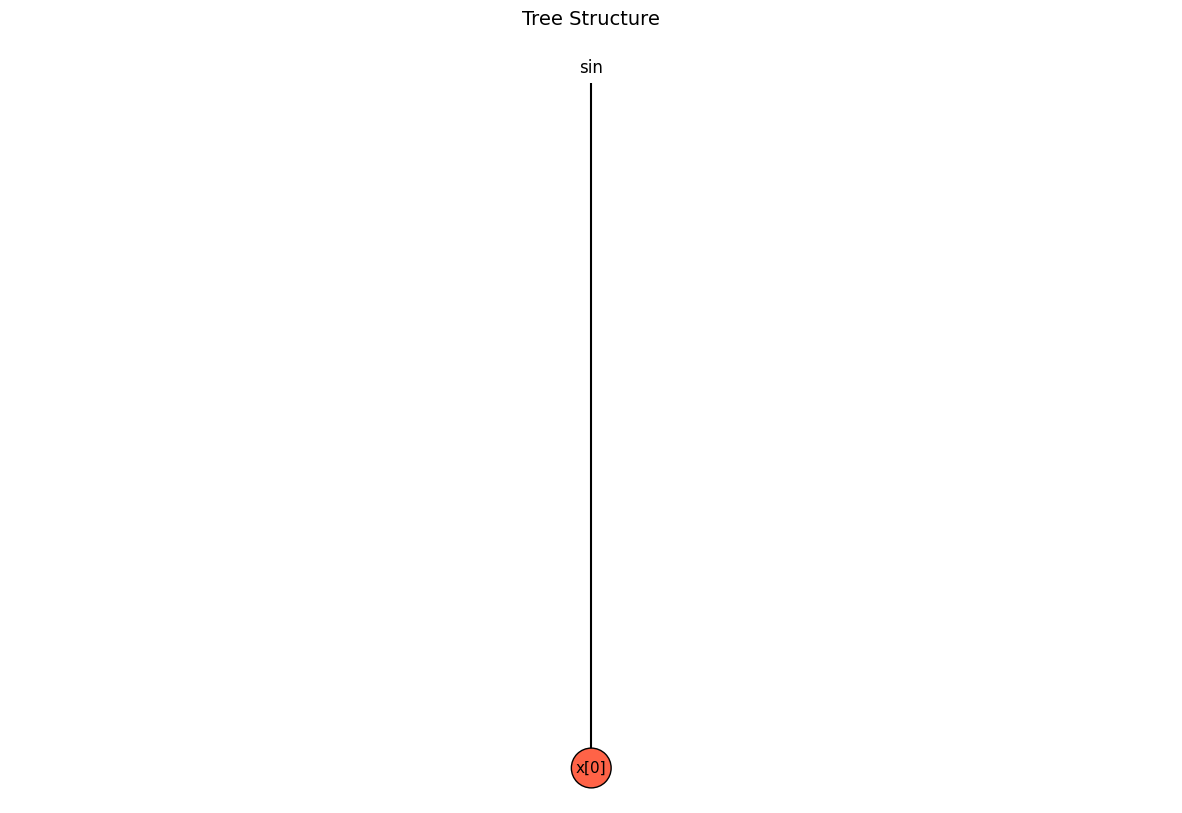

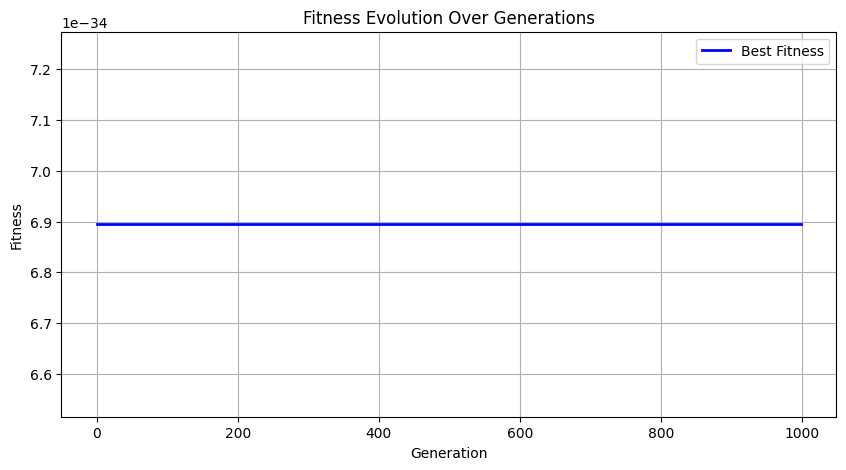

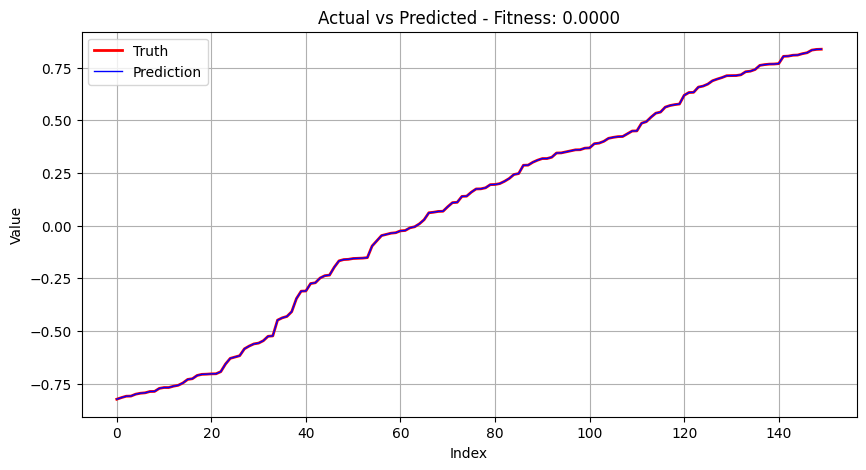

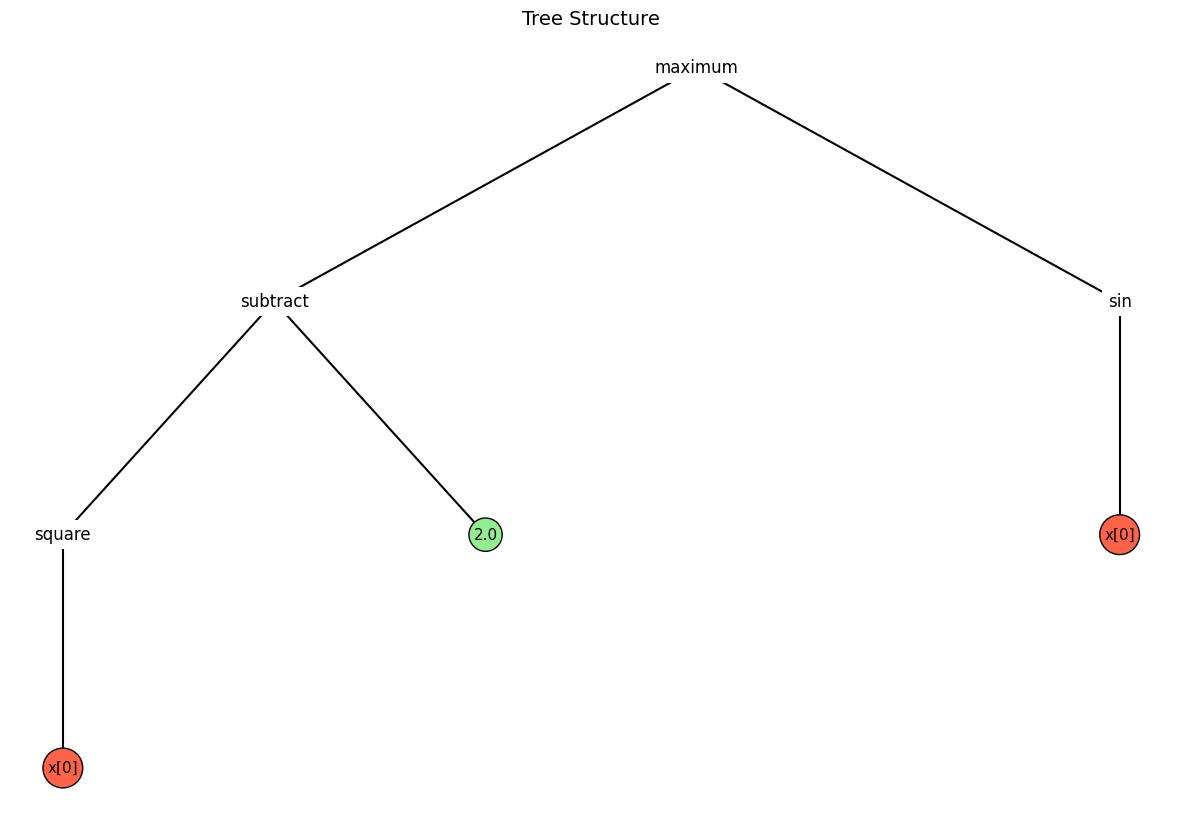

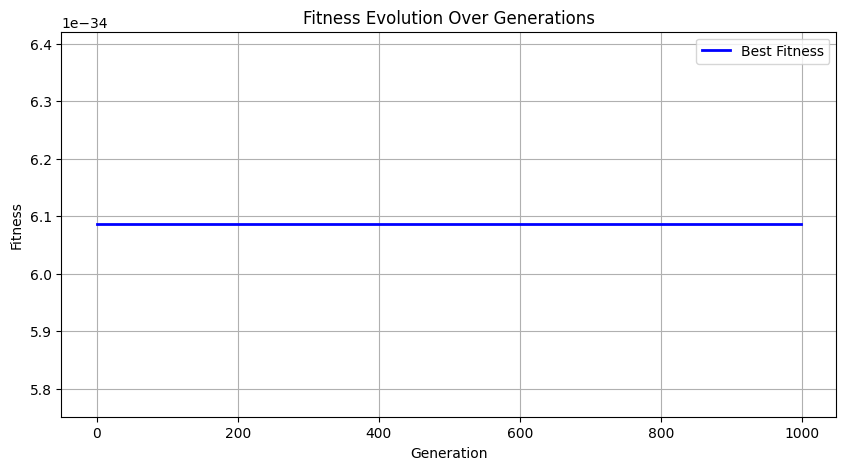

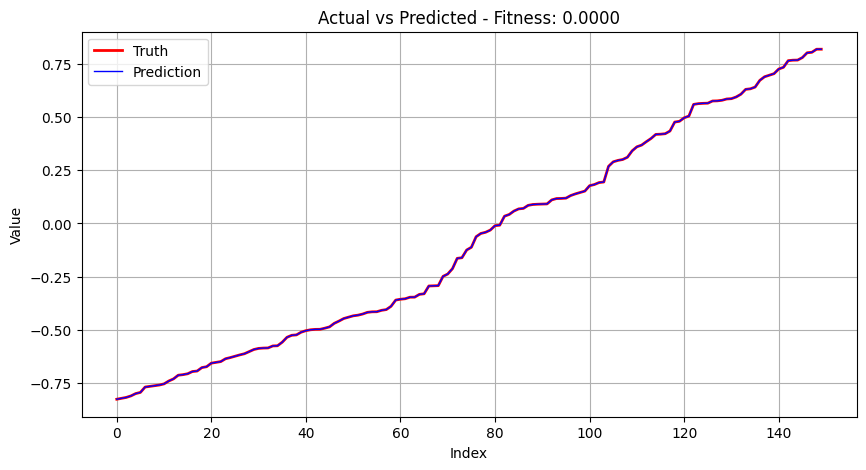

In [69]:
np.seterr(all='ignore')
run_sym_reg_gp(1)
runSymbolicRegressionMC(1)

In [ ]:
import os

RESULTS_DIR = "benchmark_results4"
os.makedirs(RESULTS_DIR, exist_ok=True)


# Helper functions to save plots


def save_tree_plot(tree, path):
    print(f"[DEBUG] Saving tree plot to {path}. Tree: {tree}")
    tree.plot()
    print(f"[DEBUG] After tree.plot(). Current figure: {plt.gcf()}")
    plt.savefig(path)
    print(f"[DEBUG] Saved tree plot to {path}")
    plt.close()


def save_fitness_trend(history, path):
    plot_fitness_trend(history)
    plt.savefig(path)
    plt.close()


def save_predictions(y_test, y_pred, fitness, path):
    plot_predictions(y_test, y_pred, fitness)
    plt.savefig(path)
    plt.close()


def run_and_collect(algorithm, dataset_num, run_num):
    problem = np.load(f'./data/problem_{dataset_num}.npz')
    x_data, y_data = problem['x'], problem['y']
    perm = np.random.permutation(len(y_data))
    x_data = x_data[:, perm]
    y_data = y_data[perm]
    train_size = int(TEST_TRAIN * len(y_data))
    x_train, y_train = x_data[:, :train_size], y_data[:train_size]
    x_test, y_test = x_data[:, train_size:], y_data[train_size:]

    if algorithm == "GP":
        model = SymbolicRegressionGP(x_train, y_train)
        best_tree, history = model.run()
    else:
        model = SymbolicRegressionMC(x_train, y_train)
        best_tree, history = model.evolve()

    test_tree = best_tree.clone_tree()
    test_tree.x_train = x_test
    test_tree.y_train = y_test
    y_pred = test_tree.compute_fitness(True)

    # Save plots
    prefix = f"{RESULTS_DIR}/ds{dataset_num}_{algorithm}_run{run_num}"
    save_tree_plot(best_tree, f"{prefix}_tree.png")
    save_fitness_trend(history, f"{prefix}_fitness.png")
    save_predictions(y_test, y_pred, test_tree.fitness, f"{prefix}_pred.png")

    return {
        "train_fitness": best_tree.fitness,
        "test_fitness": test_tree.fitness,
        "formula": str(best_tree),
        "tree_plot": f"{prefix}_tree.png",
        "fitness_plot": f"{prefix}_fitness.png",
        "pred_plot": f"{prefix}_pred.png"
    }

# Main benchmark loop
DATASETS = range(7, 9)
RUNS = 4
for ds in DATASETS:
    results = {"GP": [], "MC": []}
    for alg in ["GP", "MC"]:
        for run in range(1, RUNS+1):
            print(f"Running Dataset {ds} | {alg} | Run {run}")
            res = run_and_collect(alg, ds, run)
            results[alg].append(res)
    # Write markdown report for this dataset
    md_path = os.path.join(RESULTS_DIR, f"benchmark_dataset{ds}.md")
    with open(md_path, "w") as f:
        f.write(f"# Dataset {ds}\n\n")
        # Fitness and formula table side by side
        f.write("| Run | GP Formula | GP Train Fitness | GP Test Fitness | MC Formula | MC Train Fitness | MC Test Fitness |\n")
        f.write("|-----|------------|------------------|-----------------|------------|------------------|-----------------|\n")
        for i in range(RUNS):
            gp = results["GP"][i]
            mc = results["MC"][i]
            f.write(f"| {i+1} | {gp['formula']} | {gp['train_fitness']:.6e} | {gp['test_fitness']:.6e} | {mc['formula']} | {mc['train_fitness']:.6e} | {mc['test_fitness']:.6e} |\n")
        f.write("\n")
        # Images side by side using HTML for best compatibility
        for i in range(RUNS):
            f.write(f"<table><tr><th>GP Run {i+1}</th><th>MC Run {i+1}</th></tr>\n")
            for plot_type, label in zip(["tree_plot", "fitness_plot", "pred_plot"], ["Tree", "Fitness", "Prediction"]):
                gp_img = os.path.basename(results["GP"][i][plot_type])
                mc_img = os.path.basename(results["MC"][i][plot_type])
                f.write(f"<tr><td><img src='{gp_img}' width='320'><br>{label}</td><td><img src='{mc_img}' width='320'><br>{label}</td></tr>\n")
            f.write("</table>\n\n")
        f.write("\n---\n\n")
    print(f"Benchmark for dataset {ds} complete. Results saved in '{md_path}'")

Running Dataset 7 | GP | Run 1


Generations:  10%|█         | 100/1000 [00:41<07:32,  1.99it/s]

Gen 100 Best fitness: 230.93186200003225 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(x[1], arctan(x[0])), square(square(protected_sqrt(multiply(x[1], x[0]))))), subtract(x[0], reciprocal(minimum(x[1], x[0]))))), protected_power(protected_sqrt(multiply(x[1], x[0])), cos(arctan(tan(exp(x[0]))))))), add(exp(add(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(x[1], x[0])))), arctan(multiply(x[0], x[0])))), cosh(minimum(protected_power(reciprocal(protected_mod(protected_mod(x[0], exp(0.0)), protected_divide(protected_sqrt(multiply(x[1], x[0])), exp(x[0])))), protected_mod(square(square(absolute(x[1]))), exp(0.0))), protected_mod(arctan(protected_divide(protected_log(arctan(tan(exp(x[0])))), maximum(square(absolute(0.0)), arcsin(protected_mod(x[0], exp(0.0)))))), protected_divide(multiply(absolute(x[1]), x[1]), protected_sqrt(absolute(0.6931471805599453))))))))


Generations:  20%|██        | 200/1000 [02:18<19:41,  1.48s/it]

Gen 200 Best fitness: 180.9511243118326 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(x[0], arctan(x[0])), square(square(protected_sqrt(multiply(x[1], x[0]))))), subtract(x[0], reciprocal(minimum(add(x[0], x[0]), x[1]))))), protected_power(protected_sqrt(multiply(x[1], add(x[0], arctan(x[0])))), protected_mod(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), protected_mod(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))))))), cosh(minimum(protected_power(reciprocal(protected_mod(protected_mod

Generations:  30%|███       | 300/1000 [05:26<23:51,  2.05s/it]

Gen 300 Best fitness: 134.1183971698978 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(x[0], arctan(add(minimum(x[0], 1.7320508075688772), arctan(x[0])))), square(square(protected_sqrt(multiply(x[1], x[0]))))), subtract(x[1], protected_mod(protected_mod(x[0], exp(0.0)), protected_divide(protected_sqrt(multiply(x[0], x[0])), multiply(x[0], x[0])))))), protected_power(protected_sqrt(multiply(x[1], add(add(x[1], arctan(x[0])), arctan(x[0])))), protected_mod(protected_mod(arctan(multiply(x[1], x[0])), protected_divide(absolute(x[0]), arctan(square(absolute(x[1]))))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(minimum(x[1], 1.7320508075688772), x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))))), 

Generations:  40%|████      | 400/1000 [09:02<22:58,  2.30s/it]

Gen 400 Best fitness: 91.13383139858418 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(protected_sqrt(1.7320508075688772), x[0]), arctan(x[0])), square(add(x[1], arctan(x[0])))), subtract(x[1], protected_mod(protected_mod(minimum(x[1], x[0]), exp(0.0)), protected_divide(protected_sqrt(multiply(x[1], x[0])), exp(arctan(x[0]))))))), protected_power(protected_sqrt(multiply(x[1], add(add(multiply(protected_sqrt(1.4142135623730951), x[0]), x[0]), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), arctan(multiply(x[0], x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(absolute(x[1]), arctan(absolute(x[1])))), protected_divide(absolute(arctan(multiply(x[1], x[1]))), arctan(protected_divide(absolute(x[0]), arcta

Generations:  50%|█████     | 500/1000 [13:06<18:42,  2.24s/it]

Gen 500 Best fitness: 74.42033432233453 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(x[0])), square(add(x[1], arctan(x[0])))), subtract(x[1], protected_mod(protected_mod(minimum(x[0], x[1]), exp(0.0)), protected_divide(protected_sqrt(multiply(x[1], x[1])), exp(arctan(x[0]))))))), protected_power(protected_sqrt(multiply(x[1], add(add(multiply(protected_sqrt(1.4142135623730951), x[0]), x[0]), add(x[1], arctan(x[0]))))), protected_mod(protected_mod(arctan(multiply(x[0], x[1])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), protected_divide(absolute(x[1]), arctan(multiply(minimum(sinh(x[1]), x[0]), x[0])))), protected_divide(arctan(multiply(x[0], x[0])), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))

Generations:  60%|██████    | 600/1000 [17:29<18:12,  2.73s/it]

Gen 600 Best fitness: 65.48123626051432 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(x[0])), cosh(2.718281828459045)), subtract(x[1], protected_mod(protected_mod(minimum(x[0], x[1]), 2.0), protected_divide(protected_sqrt(multiply(x[0], x[1])), exp(arctan(x[0]))))))), protected_power(protected_sqrt(multiply(protected_divide(x[1], cos(minimum(negative(sin(0.6931471805599453)), 1.7320508075688772))), add(add(multiply(2.718281828459045, arctan(x[0])), x[0]), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), absolute(x[0]))), protected_divide(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_di

Generations:  70%|███████   | 700/1000 [21:53<12:15,  2.45s/it]

Gen 700 Best fitness: 62.207766730724366 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(x[0])), cosh(2.718281828459045)), subtract(x[1], protected_mod(protected_mod(minimum(x[0], x[1]), 2.0), protected_divide(protected_sqrt(multiply(x[1], x[1])), exp(arctan(x[0]))))))), protected_power(protected_sqrt(multiply(protected_divide(x[1], cos(minimum(negative(sin(0.6931471805599453)), 0.0))), add(add(multiply(2.718281828459045, arctan(x[0])), x[0]), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), absolute(multiply(protected_sqrt(1.4142135623730951), x[0])))), protected_divide(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(sinh(x[1]))), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), arctan(protected_divide(absolute(absolute(x[1])), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(protected_mod(arctan(mult

Generations:  80%|████████  | 800/1000 [26:48<09:12,  2.76s/it]

Gen 800 Best fitness: 59.19206485123252 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(x[0])), cosh(2.718281828459045)), subtract(x[1], protected_mod(protected_mod(minimum(x[0], x[1]), 2.0), protected_divide(protected_sqrt(multiply(x[1], x[1])), exp(arctan(cbrt(x[1])))))))), protected_power(protected_sqrt(multiply(protected_divide(x[1], cos(minimum(cos(-1.0), 1.618033988749895))), add(add(multiply(2.718281828459045, arctan(x[0])), x[0]), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), exp(0.0))), protected_divide(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(multiply(x[0], x[0])

Generations:  90%|█████████ | 900/1000 [33:58<14:39,  8.79s/it]

Gen 900 Best fitness: 56.05216860643131 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(arctan(x[0]))), cosh(2.718281828459045)), subtract(x[1], protected_mod(protected_mod(minimum(x[0], x[1]), 2.0), absolute(protected_mod(x[0], x[1])))))), protected_power(protected_sqrt(multiply(protected_divide(x[1], cos(minimum(cos(-1.0), protected_divide(1.4142135623730951, x[0])))), add(add(multiply(2.718281828459045, arctan(x[0])), arctan(x[0])), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), absolute(x[0]))), protected_divide(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(multiply(x[0], x[

Generations: 100%|██████████| 1000/1000 [50:50<00:00,  3.05s/it]

Gen 1000 Best fitness: 48.15258307052344 Formula: multiply(absolute(add(protected_sqrt(multiply(multiply(add(multiply(exp(0.0), x[0]), arctan(arctan(x[0]))), cosh(2.718281828459045)), subtract(x[1], protected_mod(protected_mod(x[1], multiply(multiply(2.302585092994046, x[0]), x[1])), absolute(protected_mod(x[0], x[1])))))), protected_power(protected_sqrt(multiply(protected_divide(x[1], cos(minimum(cos(multiply(x[0], 0.5)), protected_divide(1.4142135623730951, x[0])))), add(add(multiply(2.718281828459045, arctan(x[1])), x[0]), x[1]))), protected_mod(protected_mod(arctan(multiply(x[1], x[1])), protected_divide(multiply(x[0], x[0]), absolute(x[0]))), protected_divide(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(x[1])), protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0])))), arctan(protected_divide(absolute(x[1]), arctan(multiply(x[0], x[0]))))))))), add(exp(add(protected_mod(protected_mod(protected_mod(protected_mod(arctan(multiply(x[0], x[0])), absolute(abs

[DEBUG] Saved tree plot to benchmark_results4/ds7_GP_run1_tree.png
Running Dataset 7 | GP | Run 2
Running Dataset 7 | GP | Run 2


Generations:  10%|█         | 100/1000 [01:58<25:28,  1.70s/it]

Gen 100 Best fitness: 241.9630152940665 Formula: add(multiply(multiply(cosh(add(x[1], x[0])), protected_log(cosh(x[0]))), protected_sqrt(cosh(maximum(sinh(x[1]), x[1])))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), x[0]))), add(add(x[1], x[0]), x[0])))), add(sin(add(x[1], multiply(cos(x[0]), add(x[1], x[0])))), add(x[1], x[0])))))


Generations:  20%|██        | 200/1000 [05:22<32:17,  2.42s/it]

Gen 200 Best fitness: 89.38310189676774 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(x[1])))), add(add(x[0], x[1]), add(x[1], x[0]))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), x[1])))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(x[1])))), add(add(add(x[1], x[0]), x[1]), add(add(x[0], x[1]), add(x[1], x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(x[1], add(x[1], x[0])))))))))


Generations:  30%|███       | 300/1000 [07:32<13:33,  1.16s/it]

Gen 300 Best fitness: 68.9698699969424 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), tanh(x[1])))), add(add(x[0], x[1]), add(x[1], x[0]))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(x[1], multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(0.0, add(x[1], x[0])), add(x[1], x[0])), add(add(x[0], x[0]), add(x[1], x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(x[1], add(x[1], x[0])))))))))


Generations:  40%|████      | 400/1000 [08:55<09:18,  1.07it/s]

Gen 400 Best fitness: 66.67827545259023 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), tanh(cbrt(x[1]))))), add(add(x[0], x[1]), add(x[0], x[1]))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], x[1])), multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(0.0, add(x[1], x[0])), add(x[0], x[1])), add(add(x[0], x[0]), add(x[1], x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(multiply(1.7320508075688772, minimum(sin(x[1]), multiply(x[1], x[1]))), add(x[1], x[0])))))))))


Generations:  50%|█████     | 500/1000 [10:35<08:38,  1.04s/it]

Gen 500 Best fitness: 64.22008892835325 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(tanh(x[1]), cos(x[0])))), add(add(x[0], x[1]), add(cbrt(add(x[0], x[0])), x[1]))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], x[1])), multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(tanh(x[0]), add(x[1], x[0])), add(x[1], x[0])), add(add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), x[0]), add(x[1], x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(cbrt(add(protected_divide(1.0, x[1]), x[1])), add(x[1], multiply(cosh(0.6931471805599453), x[0]))))))))))


Generations:  60%|██████    | 600/1000 [12:19<06:51,  1.03s/it]

Gen 600 Best fitness: 63.584145108043664 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), tanh(x[1])))), add(add(minimum(x[0], x[0]), x[1]), add(x[1], cbrt(add(x[0], x[0]))))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], maximum(x[1], -1.0))), multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(tanh(x[0]), add(x[1], x[0])), add(x[1], x[0])), add(add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), minimum(x[0], 1.4142135623730951)), add(x[1], x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(cbrt(add(x[1], protected_divide(2.302585092994046, x[1]))), add(x[1], sinh(minimum(1.4142135623730951, x[0])))))))))))


Generations:  70%|███████   | 700/1000 [14:25<05:44,  1.15s/it]

Gen 700 Best fitness: 61.43135699252152 Formula: add(cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(tanh(x[1]), cos(x[0])))), add(add(x[0], x[1]), add(cbrt(add(x[0], x[0])), x[1]))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(protected_mod(x[0], x[1]), x[1])), multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(x[0], multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(tanh(x[0]), add(x[1], x[0])), add(x[1], x[0])), add(add(x[1], x[0]), add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), x[0])))))), add(add(x[1], x[0]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(x[0]), add(cbrt(add(protected_divide(3.141592653589793, x[1]), x[0])), add(x[1], protected_divide(multiply(3.141592653589793, 1.0), x[1]))))))))))


Generations:  80%|████████  | 800/1000 [16:27<03:55,  1.18s/it]

Gen 800 Best fitness: 58.549725393145515 Formula: add(cosh(add(sin(add(minimum(square(x[0]), x[0]), multiply(cos(add(x[1], multiply(cos(x[0]), tanh(x[1])))), add(add(minimum(x[0], x[0]), x[1]), add(x[1], cbrt(add(x[0], x[0]))))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], x[1])), multiply(cos(x[0]), x[1])))))))), cosh(add(sin(add(minimum(x[0], minimum(minimum(square(square(x[0])), square(x[1])), square(square(square(x[0]))))), multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(x[1], x[0]), add(tanh(x[0]), add(x[1], x[0]))), add(add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), minimum(x[0], x[0])), add(x[1], x[0])))))), add(add(minimum(minimum(add(reciprocal(1.4142135623730951), add(x[0], tanh(x[1]))), minimum(square(x[0]), x[0])), minimum(square(cbrt(add(x[1], x[1]))), x[0])), x[1]), sin(add(add(add(add(x[0], x[1]), x[1]), add(x[1], x[1])), multiply(cos(minimum(square(x[0]), x[0])), add(cbrt(add(x[1], protected_divide

Generations:  90%|█████████ | 900/1000 [18:38<02:24,  1.44s/it]

Gen 900 Best fitness: 57.40641959827071 Formula: add(cosh(add(sin(add(minimum(1.7320508075688772, minimum(square(x[0]), x[0])), multiply(cos(add(x[1], multiply(cos(x[0]), tanh(x[1])))), add(add(minimum(square(x[0]), x[0]), x[1]), add(x[1], cbrt(add(x[0], x[0]))))))), add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], x[1])), multiply(cos(x[0]), minimum(1.7320508075688772, maximum(x[1], x[1])))))))))), cosh(add(sin(add(minimum(x[0], minimum(square(add(add(x[0], x[1]), add(x[0], x[1]))), square(square(square(x[0]))))), multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(x[1], minimum(1.7320508075688772, x[0])), add(tanh(x[0]), add(x[0], x[1]))), add(add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), minimum(square(x[1]), x[0])), add(x[1], minimum(1.7320508075688772, x[0]))))))), add(add(minimum(minimum(add(reciprocal(1.4142135623730951), add(x[0], maximum(tanh(x[0]), x[1]))), x[0]), minimum(square(add(x[1], x[1])), x[0])), x[1]), si

Generations: 100%|██████████| 1000/1000 [21:12<00:00,  1.27s/it]

Gen 1000 Best fitness: 55.34280289972654 Formula: add(cosh(add(add(add(x[1], x[0]), sin(add(x[1], multiply(cos(x[0]), add(cbrt(add(x[1], x[1])), multiply(cos(x[0]), x[1])))))), sin(add(minimum(square(minimum(arctan(minimum(exp(1.618033988749895), multiply(2.0, x[0]))), square(x[0]))), x[0]), multiply(cos(add(x[1], multiply(cos(x[0]), tanh(x[1])))), add(add(minimum(1.618033988749895, x[0]), x[1]), add(x[1], cbrt(add(x[0], multiply(1.7320508075688772, x[0])))))))))), cosh(add(sin(add(minimum(x[0], minimum(minimum(square(square(x[0])), square(add(x[1], x[0]))), square(square(square(x[0]))))), multiply(cos(add(x[1], multiply(cos(x[0]), sin(cbrt(x[1]))))), add(add(add(sinh(x[1]), minimum(1.618033988749895, x[0])), add(tanh(x[0]), add(minimum(x[1], 1.4142135623730951), x[0]))), add(add(protected_mod(x[1], multiply(1.4142135623730951, x[0])), minimum(1.618033988749895, x[0])), add(x[1], minimum(1.618033988749895, x[0]))))))), add(add(minimum(minimum(add(arctan(absolute(subtract(2.718281828459

[DEBUG] Saved tree plot to benchmark_results4/ds7_GP_run2_tree.png
Running Dataset 7 | GP | Run 3


Generations:  10%|█         | 100/1000 [00:47<11:34,  1.30it/s]

Gen 100 Best fitness: 348.4691395118335 Formula: add(add(add(absolute(cosh(maximum(negative(0.0), maximum(negative(maximum(exp(protected_mod(x[0], 0.5)), x[0])), multiply(x[1], x[0]))))), protected_divide(exp(maximum(negative(maximum(x[1], x[0])), multiply(x[1], x[0]))), tanh(exp(protected_power(protected_log10(add(protected_divide(negative(x[0]), add(x[0], x[1])), maximum(minimum(1.618033988749895, 1.7320508075688772), x[1]))), arctan(tanh(add(x[1], x[0])))))))), protected_divide(exp(maximum(negative(maximum(x[1], x[0])), multiply(x[1], x[0]))), tanh(exp(protected_power(protected_log10(add(protected_divide(negative(x[0]), add(x[1], x[1])), maximum(minimum(1.618033988749895, 1.7320508075688772), protected_divide(x[1], x[0])))), multiply(x[0], x[0])))))), maximum(add(absolute(exp(maximum(negative(subtract(2.302585092994046, 0.0)), multiply(x[1], x[0])))), maximum(multiply(x[1], x[0]), exp(maximum(negative(maximum(x[1], 2.302585092994046)), multiply(x[1], x[0]))))), sin(protected_power(2

Generations:  20%|██        | 200/1000 [02:56<22:32,  1.69s/it]

Gen 200 Best fitness: 208.05445439622272 Formula: multiply(multiply(x[0], maximum(maximum(protected_divide(minimum(protected_divide(reciprocal(negative(minimum(sin(x[1]), x[1]))), -1.0), cbrt(reciprocal(negative(subtract(x[1], x[0]))))), x[0]), multiply(x[1], multiply(x[0], maximum(square(2.302585092994046), minimum(protected_divide(x[1], subtract(x[1], x[0])), exp(2.718281828459045)))))), protected_divide(subtract(reciprocal(negative(minimum(subtract(2.302585092994046, x[0]), sin(sin(x[1]))))), multiply(maximum(x[0], sin(sin(multiply(1.4142135623730951, x[0])))), reciprocal(negative(subtract(x[1], x[0]))))), negative(minimum(x[0], cbrt(maximum(cos(minimum(1.4142135623730951, maximum(2.302585092994046, x[1]))), protected_divide(1.4142135623730951, multiply(multiply(x[0], x[0]), x[0]))))))))), x[1])


Generations:  30%|███       | 300/1000 [07:18<34:18,  2.94s/it]

Gen 300 Best fitness: 116.66445384362382 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(multiply(x[0], x[1]), x[0]), subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(x[0]), x[0]), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 1.4142135623730951), multiply(multiply(x[0], x[0]), x[0])), sin(reciprocal(multiply(1.4142135623730951, x[0]))))), protected_divide(minimum(cbrt(protected_divide(x[0], subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 1.4142135623730951), multiply(multiply(x[0], 1.4142135623730951), x[0])), sin(reciprocal(multiply(1.4142135623730951, x[0])))))), protected_divide(subtract(reciprocal(negative(minimum(sin(x[1]), subtract(2.302585092994046, minimum(2.0, 2.71828

Generations:  40%|████      | 400/1000 [10:52<25:54,  2.59s/it]

Gen 400 Best fitness: 80.34642069934927 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(multiply(sinh(x[1]), x[1]), protected_log2(x[1])), subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(x[0]), x[0]), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), sin(reciprocal(multiply(1.4142135623730951, x[0]))))), protected_divide(minimum(cbrt(protected_divide(x[1], subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(add(0.5, x[0])), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[1]), multiply(1.4142135623730951, x[0])), multiply(multiply(x[0], x[0]), 1.4142135623730951)), sin(reciprocal(multiply(1.4142135623730951, x[0])))))), protected_divide(subtract(reciprocal(negative(minimum(sin(x[1]), su

Generations:  50%|█████     | 500/1000 [15:43<22:16,  2.67s/it]

Gen 500 Best fitness: 78.971459415116 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(multiply(sinh(x[1]), x[1]), protected_log2(x[1])), subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(x[0]), x[0]), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), arctan(reciprocal(multiply(1.4142135623730951, x[0]))))), protected_divide(minimum(cbrt(protected_divide(x[1], subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(add(x[0], x[0])), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[1]), multiply(1.4142135623730951, x[0])), multiply(multiply(x[0], x[0]), 1.4142135623730951)), reciprocal(multiply(1.4142135623730951, x[0]))))), protected_divide(subtract(reciprocal(negative(minimum(sin(x[1]), subtr

Generations:  60%|██████    | 600/1000 [19:12<07:50,  1.18s/it]

Gen 600 Best fitness: 74.67773147418625 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(maximum(x[1], x[0])), multiply(x[0], 1.4142135623730951)), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), sin(arctan(reciprocal(multiply(x[0], 1.4142135623730951)))))), protected_divide(minimum(cbrt(protected_divide(x[0], subtract(x[1], x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), add(x[1], multiply(1.4142135623730951, x[1]))), multiply(multiply(x[0], 1.4142135623730951), x[0])), reciprocal(multiply(x[1], 1.4142135623730951))))), protected

Generations:  70%|███████   | 700/1000 [21:09<05:57,  1.19s/it]

Gen 700 Best fitness: 70.91809071644292 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(maximum(x[1], x[0])), multiply(x[0], 1.4142135623730951)), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), sin(arctan(reciprocal(multiply(x[0], 1.4142135623730951)))))), protected_divide(minimum(cbrt(protected_divide(subtract(multiply(1.4142135623730951, x[0]), 0.6931471805599453), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), add(x[1], multiply(1.4142135623730951, x[1]))), multiply(multiply(x[0], 1.414213562373

Generations:  80%|████████  | 800/1000 [23:40<05:19,  1.60s/it]

Gen 800 Best fitness: 65.80796509176946 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(maximum(x[1], x[0])), multiply(x[0], 1.4142135623730951)), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), reciprocal(multiply(1.618033988749895, maximum(x[1], x[0]))))), protected_divide(minimum(cbrt(protected_divide(subtract(multiply(1.4142135623730951, x[0]), protected_divide(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), add(x[1], multiply(1.4142135623730951, x[1]))), multiply(multiply(x[0], 1.4

Generations:  90%|█████████ | 900/1000 [25:50<02:08,  1.28s/it]

Gen 900 Best fitness: 64.77801660890411 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(maximum(x[1], x[0])), multiply(x[0], 1.4142135623730951)), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), reciprocal(multiply(1.618033988749895, maximum(x[1], x[0]))))), protected_divide(minimum(cbrt(protected_divide(subtract(multiply(1.4142135623730951, x[0]), protected_divide(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), add(x[1], multiply(1.4142135623730951, x[1]))), multiply(multiply(x[0], 1.4

Generations:  90%|█████████ | 902/1000 [25:52<02:07,  1.30s/it]

Gen 902 Stagnation detected


Generations: 100%|██████████| 1000/1000 [27:56<00:00,  1.68s/it]

Gen 1000 Best fitness: 64.01450217898808 Formula: multiply(multiply(x[0], maximum(add(protected_divide(minimum(cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(maximum(x[1], x[0])), multiply(x[0], 1.4142135623730951)), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), 2.302585092994046), multiply(multiply(x[0], x[0]), x[0])), reciprocal(multiply(1.618033988749895, maximum(x[1], x[0]))))), protected_divide(minimum(cbrt(protected_divide(subtract(multiply(1.4142135623730951, x[0]), protected_divide(x[1], x[1])), subtract(maximum(x[1], x[0]), x[0]))), cbrt(protected_divide(multiply(protected_log2(x[1]), multiply(1.4142135623730951, x[0])), subtract(x[1], x[0])))), minimum(protected_divide(protected_mod(protected_divide(protected_log2(x[1]), x[0]), add(x[1], multiply(1.4142135623730951, x[1]))), multiply(multiply(x[0], 1.

[DEBUG] Saved tree plot to benchmark_results4/ds7_GP_run3_tree.png
Running Dataset 7 | GP | Run 4


Generations:  10%|█         | 100/1000 [00:55<09:33,  1.57it/s]

Gen 100 Best fitness: 244.25922219953276 Formula: exp(minimum(maximum(add(2.302585092994046, reciprocal(absolute(reciprocal(protected_sqrt(negative(multiply(x[0], multiply(x[0], x[0])))))))), add(negative(1.618033988749895), add(minimum(protected_divide(1.4142135623730951, x[0]), protected_sqrt(x[0])), add(absolute(maximum(negative(1.618033988749895), multiply(1.618033988749895, cosh(x[1])))), protected_mod(cbrt(cosh(protected_log(1.0))), x[0]))))), maximum(absolute(protected_mod(subtract(protected_power(add(minimum(protected_divide(2.0, x[0]), 1.0), minimum(absolute(0.5), protected_power(1.0, 0.6931471805599453))), 1.0), protected_power(tan(0.5), exp(minimum(x[1], protected_sqrt(x[0]))))), 1.618033988749895)), add(multiply(x[1], x[0]), absolute(maximum(subtract(protected_power(add(minimum(protected_divide(2.0, x[0]), subtract(1.0, 1.4142135623730951)), minimum(absolute(0.5), protected_power(1.0, 0.6931471805599453))), 1.0), protected_power(arccos(negative(tanh(x[0]))), exp(minimum(x[1

Generations:  20%|██        | 200/1000 [02:07<09:19,  1.43it/s]

Gen 200 Best fitness: 178.7375719292317 Formula: add(sinh(minimum(maximum(add(minimum(square(x[1]), square(protected_log2(maximum(x[1], protected_divide(cosh(x[0]), tanh(1.4142135623730951)))))), x[0]), add(minimum(square(x[1]), minimum(square(x[1]), square(x[0]))), 2.0)), square(minimum(maximum(add(arctan(protected_log10(x[0])), arctan(protected_mod(1.7320508075688772, x[1]))), add(x[1], x[0])), tan(protected_power(exp(3.141592653589793), 2.0)))))), cosh(minimum(minimum(maximum(maximum(add(minimum(minimum(square(x[1]), protected_mod(minimum(x[1], x[0]), x[0])), maximum(add(x[1], x[0]), add(-1.0, 0.0))), add(x[1], square(x[0]))), add(minimum(square(2.0), square(x[0])), 2.0)), maximum(x[0], add(-1.0, 0.0))), square(minimum(square(arccos(sin(minimum(x[1], subtract(x[0], x[1]))))), maximum(add(x[1], x[0]), add(-1.0, 0.0))))), add(x[1], maximum(add(x[1], x[1]), subtract(add(arctan(x[0]), minimum(square(x[0]), arctan(protected_log10(x[0])))), add(-1.0, protected_log2(square(x[0])))))))))


Generations:  30%|███       | 300/1000 [03:38<10:56,  1.07it/s]

Gen 300 Best fitness: 136.81738883095431 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_mod(subtract(x[0], x[1]), add(2.302585092994046, subtract(x[0], x[1])))), square(protected_log2(maximum(arctan(x[1]), protected_divide(cosh(x[0]), tanh(1.4142135623730951)))))), x[1]), add(minimum(square(x[1]), square(x[0])), 2.0)), square(minimum(maximum(add(x[1], x[0]), minimum(square(square(exp(x[1]))), arctan(protected_log10(protected_log10(-1.0))))), tan(protected_power(exp(3.141592653589793), 2.0)))))), cosh(minimum(minimum(maximum(maximum(subtract(x[0], x[1]), add(minimum(square(subtract(x[0], add(x[1], x[1]))), square(x[0])), 2.0)), x[1]), square(minimum(maximum(protected_power(2.0, x[1]), 0.0), maximum(add(add(-1.0, x[0]), x[0]), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, subtract(x[0], x[1]))))))), add(minimum(protected_log2(cbrt(protected_mod(subtract(x[0], x[1]), add(2.302585092994046, -1.0)))), arctan(protected_log10(add(x[1], x[1])))), maximum(add(x[1], 

Generations:  40%|████      | 400/1000 [05:37<12:21,  1.24s/it]

Gen 400 Best fitness: 100.52260912586989 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_mod(subtract(x[0], x[1]), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, x[1])))), square(protected_log2(maximum(subtract(x[0], x[1]), protected_divide(cosh(x[0]), tanh(1.4142135623730951)))))), x[1]), add(minimum(square(x[1]), square(x[0])), 2.0)), square(minimum(tan(protected_power(exp(3.141592653589793), 2.0)), maximum(add(x[1], x[0]), minimum(square(square(add(-1.0, x[0]))), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, subtract(x[0], x[1]))))))))), cosh(minimum(minimum(maximum(maximum(square(protected_mod(subtract(x[0], x[1]), add(2.302585092994046, subtract(x[0], x[1])))), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), 2.302585092994046)), x[0]), square(minimum(maximum(protected_power(2.0, x[1]), minimum(x[0], arctan(protected_log10(x[0])))), maximum(add(square(x[0]), subtract(x[0], x[1])), protected_mod(subtract(x[0], x[1]), add(2.

Generations:  50%|█████     | 500/1000 [08:35<14:01,  1.68s/it]

Gen 500 Best fitness: 74.1231167329944 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_mod(subtract(x[0], x[1]), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, x[1])))), square(protected_log2(maximum(arctan(x[1]), protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951)))))), x[1]), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), 2.302585092994046)), square(minimum(maximum(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(x[1], arctan(protected_log10(x[0])))), maximum(add(x[1], x[0]), minimum(square(square(add(-1.0, x[0]))), protected_mod(subtract(x[0], x[1]), add(subtract(x[0], x[1]), 2.302585092994046)))))))), cosh(minimum(minimum(maximum(maximum(square(protected_mod(subtract(x[0], x[1]), add(2.302585092994046, subtract(x[0], x[1])))), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), 2.302585092994046)), minimum(square(square(add(-1.0, maximum(x[1], x[0])))), protected_mod(subtract(x[0], x[1]), 

Generations:  60%|██████    | 600/1000 [11:41<12:14,  1.84s/it]

Gen 600 Best fitness: 64.51110759936333 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_log2(maximum(subtract(x[0], x[1]), protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951))))), square(protected_mod(add(tanh(1.4142135623730951), x[0]), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, x[1]))))), minimum(maximum(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(x[1], arctan(x[0]))), subtract(add(add(2.302585092994046, subtract(absolute(2.0), x[1])), subtract(x[0], x[1])), protected_mod(subtract(multiply(x[1], x[0]), subtract(x[0], x[1])), square(x[0]))))), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), add(2.302585092994046, subtract(x[0], x[1])))), square(minimum(maximum(protected_power(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(square(x[1]), square(x[0]))), tan(cos(subtract(x[0], x[1])))), maximum(add(x[1], 2.302585092994046), minimum(square(square(add(-1.0, x[0]))), protected_mod(subtr

Generations:  70%|███████   | 700/1000 [15:21<09:11,  1.84s/it]

Gen 700 Best fitness: 52.873667364404284 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_log2(maximum(subtract(x[0], x[1]), protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951))))), square(protected_mod(add(tanh(x[1]), tan(protected_mod(x[0], x[1]))), protected_mod(subtract(x[0], x[1]), add(x[0], 2.302585092994046))))), minimum(maximum(protected_power(2.0, minimum(square(x[1]), square(x[0]))), x[1]), subtract(add(add(2.302585092994046, subtract(absolute(2.0), x[1])), subtract(2.0, x[1])), protected_mod(subtract(multiply(x[1], x[0]), subtract(x[0], x[1])), square(x[0]))))), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), add(2.302585092994046, tanh(subtract(x[0], x[1]))))), square(minimum(maximum(protected_power(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(square(x[1]), add(2.302585092994046, subtract(x[0], x[1])))), tan(cos(subtract(x[0], x[1])))), maximum(add(x[1], 2.302585092994046), minimum(square(protected_log10(x[

Generations:  80%|████████  | 800/1000 [19:00<10:17,  3.09s/it]

Gen 800 Best fitness: 48.95651082736082 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_log2(maximum(x[1], protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951))))), square(protected_mod(add(tanh(x[0]), tan(protected_mod(x[0], x[1]))), protected_mod(subtract(x[0], x[1]), add(x[0], 2.302585092994046))))), minimum(maximum(protected_power(2.0, minimum(square(x[1]), square(x[0]))), 2.302585092994046), subtract(add(add(2.302585092994046, subtract(absolute(2.0), x[1])), subtract(2.0, x[1])), protected_mod(subtract(multiply(x[1], x[1]), subtract(x[1], x[1])), square(x[0]))))), add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), add(2.302585092994046, tanh(subtract(x[0], x[1]))))), square(minimum(maximum(protected_power(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(square(x[1]), add(2.302585092994046, subtract(x[0], x[1])))), tan(cos(subtract(x[0], x[1])))), maximum(add(add(x[1], x[1]), 2.302585092994046), minimum(square(protected_l

Generations:  90%|█████████ | 900/1000 [22:27<03:39,  2.20s/it]

Gen 900 Best fitness: 43.333740498409284 Formula: add(sinh(minimum(maximum(add(minimum(square(protected_log2(maximum(subtract(absolute(x[1]), x[0]), protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951))))), square(protected_mod(subtract(multiply(x[1], x[0]), subtract(2.302585092994046, x[1])), protected_mod(subtract(x[0], x[1]), add(2.302585092994046, 2.302585092994046))))), minimum(square(square(add(-1.0, minimum(square(x[1]), 2.302585092994046)))), subtract(add(add(2.302585092994046, subtract(absolute(2.0), x[1])), subtract(protected_power(1.4142135623730951, x[0]), x[1])), protected_mod(subtract(multiply(x[1], x[0]), subtract(x[0], x[1])), square(x[0]))))), add(minimum(minimum(multiply(x[1], x[0]), square(x[0])), square(subtract(x[0], add(x[1], x[1])))), add(2.302585092994046, tanh(tanh(subtract(x[0], x[1])))))), square(minimum(maximum(protected_power(protected_power(2.302585092994046, minimum(square(x[1]), square(x[0]))), tan(cos(subtract(x[0], x[1])))), tan(cos(subtract

Generations: 100%|██████████| 1000/1000 [26:41<00:00,  1.60s/it]

Gen 1000 Best fitness: 36.42269488639687 Formula: add(sinh(minimum(maximum(add(minimum(square(x[0]), square(subtract(x[0], add(x[1], x[1])))), add(2.302585092994046, subtract(x[0], x[1]))), add(minimum(square(protected_log2(maximum(protected_divide(multiply(x[0], x[0]), tanh(1.4142135623730951)), 2.302585092994046))), square(protected_mod(subtract(x[0], x[1]), add(maximum(-1.0, maximum(x[0], x[1])), x[1])))), minimum(maximum(subtract(x[0], 2.302585092994046), protected_power(1.618033988749895, minimum(square(x[1]), square(x[0])))), subtract(add(add(2.302585092994046, subtract(absolute(2.0), x[1])), subtract(2.0, x[1])), protected_mod(subtract(multiply(x[1], x[1]), subtract(x[0], x[1])), square(x[0])))))), square(minimum(maximum(protected_power(protected_power(2.0, minimum(square(x[1]), square(x[0]))), minimum(subtract(sinh(cbrt(2.302585092994046)), subtract(x[0], x[1])), add(2.302585092994046, subtract(x[0], x[1])))), tan(cos(subtract(x[0], x[1])))), maximum(add(x[1], 2.718281828459045

[DEBUG] After tree.plot(). Current figure: Figure(1500x1000)
[DEBUG] Saved tree plot to benchmark_results4/ds7_GP_run4_tree.png
Running Dataset 7 | MC | Run 1
[DEBUG] Saved tree plot to benchmark_results4/ds7_GP_run4_tree.png
Running Dataset 7 | MC | Run 1


Generations:  10%|█         | 100/1000 [00:53<08:56,  1.68it/s]

Gen 100 | Best fitness: 97.069579 | Temp: 0.133 | MutRate: 0.303 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(x[0], exp(tanh(subtract(minimum(x[1], add(cos(2.302585092994046), arctan(1.618033988749895))), x[0]))))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(reciprocal(tan(sin(protected_log10(minimum(cosh(x[0]), x[1]))))), subtract(subtract(x[0], maximum(add(x[1], x[1]), exp(tanh(x[1])))), reciprocal(tan(sin(protected_log10(minimum(cosh(x[0]), x[1]))))))))), 2.0)


Generations:  20%|██        | 200/1000 [02:21<13:50,  1.04s/it]

Gen 200 | Best fitness: 69.675633 | Temp: 0.018 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(x[1], x[0]))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(cbrt(subtract(x[1], 0.0)), x[1]), exp(minimum(x[1], 0.0)))), reciprocal(tan(sin(protected_log10(minimum(x[1], 0.0)))))), reciprocal(subtract(minimum(cosh(x[1]), x[1]), x[0]))))), 2.0)


Generations:  30%|███       | 300/1000 [04:54<20:48,  1.78s/it]

Gen 300 | Best fitness: 46.556422 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(add(x[1], add(subtract(x[1], x[0]), x[1])), cbrt(subtract(subtract(x[1], x[0]), x[0]))), sinh(x[0])))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(cbrt(x[1]), x[1]), exp(minimum(x[1], 0.0)))), reciprocal(tan(sin(protected_log10(minimum(0.0, 0.0)))))), reciprocal(subtract(minimum(x[1], add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1]))), x[0]))))), 2.0)


Generations:  40%|████      | 400/1000 [07:24<15:46,  1.58s/it]

Gen 400 | Best fitness: 42.927606 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(add(add(subtract(x[1], x[0]), x[1]), add(subtract(x[1], x[0]), x[1])), protected_mod(x[0], minimum(x[1], minimum(x[0], 2.0)))), sinh(minimum(x[1], x[0]))))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_sqrt(x[1]), x[1]), exp(minimum(x[0], subtract(x[1], x[0]))))), reciprocal(tan(sin(protected_log10(minimum(0.0, x[1])))))), reciprocal(subtract(minimum(x[1], add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1]))), x[0]))))), 2.0)


Generations:  50%|█████     | 500/1000 [10:14<19:52,  2.38s/it]

Gen 500 | Best fitness: 42.456966 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(x[0], minimum(x[0], minimum(-1.0, x[1]))), add(add(minimum(-1.0, x[1]), subtract(x[1], x[0])), add(subtract(x[1], x[0]), x[1]))), sinh(minimum(x[0], x[1]))))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_sqrt(x[1]), minimum(x[1], x[0])), exp(minimum(-1.0, protected_sqrt(x[1]))))), reciprocal(tan(sin(protected_log10(protected_log10(0.0)))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1])), add(subtract(x[1], x[0]), add(subtract(x[1], x[1]), x[1]))), x[0]))))), 2.0)


Generations:  60%|██████    | 600/1000 [12:45<09:17,  1.39s/it]

Gen 600 | Best fitness: 41.785339 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(subtract(x[1], x[0]), protected_log(square(x[0]))), add(add(minimum(-1.0, x[1]), subtract(x[1], x[0])), add(minimum(-1.0, x[1]), subtract(x[1], x[0])))), sinh(x[0])))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_log(square(x[0])), x[1]), exp(minimum(-1.0, subtract(x[1], x[0]))))), reciprocal(tan(sin(protected_log10(protected_log10(0.0)))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1])), add(x[1], x[0])), x[0]))))), 2.0)


Generations:  70%|███████   | 700/1000 [15:06<07:15,  1.45s/it]

Gen 700 | Best fitness: 37.934416 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(sinh(minimum(subtract(subtract(x[0], maximum(add(protected_log(add(x[1], x[0])), x[1]), exp(minimum(x[0], subtract(x[1], x[0]))))), reciprocal(tan(sin(protected_log10(protected_log10(0.0)))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1])), add(subtract(x[1], x[0]), x[1])), x[0])))), add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(subtract(x[0], subtract(x[0], protected_log10(x[0]))), protected_log(subtract(protected_mod(3.141592653589793, x[1]), x[0]))), add(protected_log(subtract(x[1], x[0])), add(x[1], square(sin(2.302585092994046))))), sinh(x[0])))), protected_divide(sinh(x[0]), cbrt(subtract(x[1], x[0]))))), 2.0)


Generations:  80%|████████  | 800/1000 [17:47<04:33,  1.37s/it]

Gen 800 | Best fitness: 36.494864 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(-1.0, protected_log(subtract(x[1], x[0]))), add(add(-1.0, subtract(x[1], x[0])), protected_log(subtract(x[1], x[0])))), sinh(x[0])))), protected_divide(sinh(maximum(minimum(add(protected_log(add(1.0, x[0])), add(x[1], sinh(x[0]))), cos(protected_power(protected_mod(tanh(1.618033988749895), 0.5), x[1]))), x[0])), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_log(add(x[1], x[0])), x[1]), exp(minimum(-1.0, subtract(x[0], x[0]))))), reciprocal(tan(sin(protected_log10(protected_log10(0.0)))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1])), add(protected_log(add(1.0, x[0])), x[0])), x[0]))))), 2.0)


Generations:  90%|█████████ | 900/1000 [20:01<02:13,  1.34s/it]

Gen 900 | Best fitness: 35.965392 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(protected_power(subtract(x[1], x[0]), -1.0), protected_log(subtract(x[1], x[0]))), add(protected_log(subtract(x[1], x[0])), add(x[1], subtract(cbrt(x[1]), x[0])))), sinh(x[0])))), protected_divide(sinh(maximum(minimum(add(protected_sqrt(protected_power(x[1], x[0])), add(x[0], maximum(x[1], multiply(x[0], 3.141592653589793)))), cos(protected_power(protected_mod(tanh(1.618033988749895), 0.5), x[1]))), x[0])), cbrt(subtract(x[1], x[0])))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_log(add(x[1], x[0])), x[1]), exp(minimum(-1.0, subtract(x[0], x[0]))))), reciprocal(tan(sin(protected_log10(protected_log10(0.0)))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(x[1], subtract(x[1],

Generations: 100%|██████████| 1000/1000 [22:15<00:00,  1.34s/it]

Gen 1000 | Best fitness: 34.987526 | Temp: 0.010 | MutRate: 0.200 | Formula: protected_power(maximum(add(protected_divide(sinh(maximum(minimum(cos(protected_power(protected_mod(tanh(1.4142135623730951), 0.5), x[1])), add(add(add(x[1], tanh(0.5)), add(x[1], x[1])), protected_log(add(1.0, x[0])))), x[0])), cbrt(subtract(x[1], x[0]))), add(protected_divide(sinh(x[0]), cbrt(cbrt(subtract(x[1], x[0])))), maximum(cbrt(protected_divide(sinh(sinh(x[0])), cbrt(cbrt(subtract(x[1], x[0]))))), subtract(minimum(protected_mod(tanh(0.5), protected_log(subtract(x[1], x[0]))), add(add(subtract(x[1], x[0]), add(0.5, x[1])), protected_log(subtract(x[1], x[0])))), sinh(x[0]))))), sinh(minimum(subtract(subtract(x[0], maximum(add(protected_log(add(x[1], x[0])), x[1]), exp(minimum(-1.0, subtract(x[1], x[1]))))), reciprocal(tan(sin(protected_log10(subtract(exp(0.6931471805599453), negative(1.618033988749895))))))), reciprocal(subtract(minimum(add(subtract(x[1], x[0]), add(subtract(x[1], x[0]), x[1])), x[0]), 

[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run1_tree.png
Running Dataset 7 | MC | Run 2


Generations:  10%|█         | 100/1000 [00:46<12:55,  1.16it/s]

Gen 100 | Best fitness: 250.931480 | Temp: 0.133 | MutRate: 0.303 | Formula: absolute(multiply(multiply(protected_log10(protected_divide(multiply(protected_divide(x[0], 2.302585092994046), x[1]), reciprocal(subtract(minimum(cosh(0.0), protected_log(x[0])), x[0])))), x[1]), multiply(maximum(maximum(maximum(protected_log10(maximum(2.0, x[1])), minimum(x[0], x[1])), arctan(subtract(x[0], x[1]))), add(negative(multiply(x[1], maximum(2.0, 1.7320508075688772))), protected_divide(x[0], 2.302585092994046))), multiply(maximum(maximum(protected_log10(arctan(subtract(x[0], x[1]))), minimum(x[1], arctan(x[0]))), maximum(protected_log10(x[0]), minimum(x[0], x[1]))), maximum(maximum(protected_log10(x[1]), minimum(x[0], x[1])), subtract(x[1], maximum(maximum(protected_log10(x[1]), minimum(x[0], x[1])), subtract(x[0], x[1]))))))))


Generations:  20%|██        | 200/1000 [02:30<15:38,  1.17s/it]

Gen 200 | Best fitness: 176.615404 | Temp: 0.018 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(minimum(x[0], x[1]), minimum(x[0], minimum(x[0], x[1]))), subtract(subtract(x[1], maximum(reciprocal(x[1]), subtract(minimum(x[0], x[1]), maximum(x[1], x[0])))), maximum(maximum(x[0], x[1]), subtract(minimum(x[0], x[1]), maximum(x[1], x[0]))))), protected_log10(protected_divide(multiply(x[0], x[1]), reciprocal(subtract(minimum(maximum(protected_log10(x[1]), minimum(x[0], x[1])), protected_log(protected_log10(x[0]))), x[0]))))), multiply(maximum(maximum(maximum(protected_log10(x[0]), minimum(x[1], add(protected_divide(x[0], x[1]), subtract(maximum(x[1], x[1]), x[1])))), minimum(x[1], add(protected_divide(x[0], x[1]), subtract(maximum(x[1], x[1]), x[1])))), add(subtract(maximum(2.0, x[1]), maximum(x[1], x[0])), maximum(maximum(protected_log10(maximum(x[1], minimum(x[0], x[1]))), minimum(x[0], minimum(x[1], x[1]))), subtract(minimum(x[0], x[1]), x[1])))), multiply(maximu

Generations:  30%|███       | 300/1000 [04:34<15:36,  1.34s/it]

Gen 300 | Best fitness: 141.681776 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(maximum(maximum(reciprocal(x[0]), subtract(minimum(x[1], x[0]), cos(minimum(x[0], tanh(x[0]))))), minimum(x[1], add(protected_divide(tanh(protected_log2(x[0])), x[1]), subtract(x[1], x[1])))), minimum(subtract(maximum(x[0], x[1]), x[0]), add(minimum(x[0], x[0]), subtract(maximum(x[1], maximum(0.0, x[1])), x[0])))), add(subtract(maximum(2.0, x[1]), maximum(x[1], minimum(x[0], x[0]))), maximum(maximum(reciprocal(maximum(negative(x[1]), x[1])), subtract(minimum(x[1], x[0]), cos(minimum(x[0], x[1])))), subtract(x[0], x[1])))), multiply(maximum(maximum(protected_log10(arctan(subtract(x[0], x[1]))), minimum(x[1], add(protected_divide(x[1], x[1]), subtract(maximum(x[0], x[1]), x[1])))), maximum(subtract(minimum(x[1], subtract(minimum(x[0], x[1]), x[1])), maximum(reciprocal(x[0]), subtract(minimum(x[0], x[1]), x[1]))), minimum(2.0, minimum(x[0], x[1])))), maximum(maximum(subt

Generations:  40%|████      | 400/1000 [07:09<13:40,  1.37s/it]

Gen 400 | Best fitness: 100.746431 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(minimum(minimum(protected_divide(multiply(x[0], x[0]), x[1]), minimum(x[0], x[1])), add(subtract(minimum(x[0], x[1]), protected_divide(multiply(x[0], x[0]), x[1])), minimum(x[0], minimum(x[0], x[1])))), minimum(protected_log(maximum(2.0, x[0])), x[0])), subtract(subtract(subtract(x[1], maximum(minimum(x[0], x[1]), subtract(minimum(x[0], x[1]), x[1]))), subtract(minimum(minimum(x[0], minimum(x[1], x[1])), protected_divide(multiply(x[0], x[0]), x[1])), maximum(x[0], x[1]))), maximum(maximum(sinh(minimum(absolute(square(0.5)), protected_log10(0.5))), x[1]), subtract(minimum(minimum(x[0], minimum(x[0], x[1])), protected_divide(multiply(x[0], x[0]), x[1])), maximum(x[0], x[1]))))), protected_log10(protected_divide(multiply(x[0], x[1]), reciprocal(subtract(minimum(maximum(protected_log10(x[0]), minimum(x[1], x[1])), protected_log(x[0])), x[0]))))), multiply(maximum(maximum(

Generations:  50%|█████     | 500/1000 [10:21<16:29,  1.98s/it]

Gen 500 | Best fitness: 84.211650 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(minimum(minimum(protected_divide(multiply(x[0], x[0]), x[1]), maximum(x[0], x[1])), add(subtract(x[1], protected_divide(multiply(x[0], x[0]), x[1])), minimum(x[0], x[1]))), minimum(protected_log(maximum(2.0, x[0])), x[1])), subtract(subtract(subtract(minimum(x[1], reciprocal(minimum(x[0], x[1]))), maximum(minimum(x[0], x[1]), subtract(minimum(x[0], x[1]), maximum(x[0], x[1])))), subtract(minimum(minimum(x[0], minimum(x[1], x[1])), protected_divide(multiply(x[0], x[0]), x[1])), maximum(x[0], x[1]))), maximum(maximum(sinh(minimum(exp(subtract(2.302585092994046, 1.7320508075688772)), protected_log10(0.5))), x[0]), subtract(minimum(minimum(x[1], minimum(x[0], x[1])), protected_divide(multiply(x[0], x[0]), x[1])), maximum(x[0], x[1]))))), protected_log10(protected_divide(multiply(x[0], x[1]), reciprocal(subtract(minimum(minimum(x[1], protected_log(x[1])), protected_log(x[0]

Generations:  60%|██████    | 600/1000 [13:56<12:23,  1.86s/it]

Gen 600 | Best fitness: 70.813348 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(protected_log10(protected_divide(multiply(protected_divide(maximum(negative(1.618033988749895), x[0]), 2.302585092994046), maximum(x[1], x[1])), protected_log10(minimum(maximum(negative(1.618033988749895), x[0]), arctan(protected_log10(x[0])))))), multiply(maximum(maximum(protected_log10(arctan(arctan(subtract(x[0], x[1])))), subtract(subtract(x[1], maximum(x[0], subtract(x[0], x[1]))), maximum(maximum(x[1], x[1]), subtract(x[0], x[1])))), maximum(minimum(cosh(protected_mod(x[0], 0.5)), multiply(x[1], maximum(x[1], 1.7320508075688772))), minimum(x[0], subtract(x[1], protected_mod(protected_power(1.4142135623730951, x[1]), subtract(x[0], x[1])))))), maximum(maximum(minimum(x[0], maximum(protected_log10(multiply(2.302585092994046, 2.302585092994046)), subtract(x[0], protected_mod(protected_power(1.4142135623730951, x[1]), x[0])))), protected_log10(maximum(0.0, subtract(cbrt(protected_lo

Generations:  70%|███████   | 700/1000 [18:13<12:35,  2.52s/it]

Gen 700 | Best fitness: 39.719002 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(protected_log10(protected_divide(multiply(protected_divide(x[0], square(maximum(protected_divide(x[0], 2.302585092994046), x[0]))), maximum(x[0], x[1])), protected_log10(protected_log10(arctan(add(x[1], protected_mod(x[1], 0.5))))))), multiply(maximum(maximum(protected_log10(arctan(arctan(subtract(x[0], x[1])))), subtract(subtract(x[0], maximum(subtract(x[0], x[1]), x[1])), maximum(maximum(x[0], x[1]), maximum(negative(x[1]), 1.4142135623730951)))), maximum(minimum(multiply(x[1], add(maximum(x[0], 2.302585092994046), protected_mod(x[0], 0.5))), arcsin(1.0)), minimum(protected_log10(protected_divide(cosh(x[0]), subtract(x[1], x[0]))), subtract(maximum(x[1], 0.5), protected_mod(protected_log10(1.4142135623730951), subtract(x[0], 2.302585092994046)))))), maximum(maximum(minimum(x[0], maximum(protected_log10(multiply(2.302585092994046, 2.302585092994046)), subtract(x[0], protected_mod(pro

Generations:  80%|████████  | 800/1000 [22:06<08:08,  2.44s/it]

Gen 800 | Best fitness: 20.807072 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(maximum(reciprocal(square(maximum(protected_divide(x[0], 2.0), x[0]))), maximum(protected_log10(protected_divide(cosh(x[0]), subtract(x[0], x[1]))), protected_log10(protected_divide(cosh(x[0]), subtract(maximum(x[1], 0.0), x[0]))))), arctan(maximum(arctan(maximum(protected_divide(x[0], x[0]), subtract(x[0], x[0]))), protected_divide(maximum(protected_divide(x[0], x[1]), x[0]), protected_log(-1.0))))), add(negative(multiply(x[1], add(maximum(x[1], 2.0), maximum(subtract(x[0], x[1]), subtract(x[0], x[0]))))), protected_divide(arctan(arctan(subtract(x[0], x[1]))), protected_log10(2.302585092994046)))), multiply(maximum(maximum(protected_log10(arctan(subtract(x[0], x[1]))), subtract(minimum(minimum(2.302585092994046, x[0]), protected_divide(x[1], x[0])), maximum(maximum(protected_divide(x[0], 2.302585092994046), x[1]), subtract(x[1], x[0])))), maximum(minimum(protected_log

Generations:  90%|█████████ | 900/1000 [26:25<03:42,  2.23s/it]

Gen 900 | Best fitness: 17.769324 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(maximum(reciprocal(square(maximum(protected_divide(x[0], 2.0), x[0]))), maximum(protected_log10(protected_divide(add(multiply(x[1], x[0]), absolute(0.6931471805599453)), subtract(x[0], x[1]))), protected_log10(protected_divide(maximum(3.141592653589793, x[0]), subtract(maximum(x[1], 0.0), x[0]))))), arctan(maximum(arctan(maximum(protected_divide(x[0], x[0]), subtract(x[1], x[0]))), protected_divide(protected_log(-1.0), maximum(protected_divide(x[0], x[0]), 2.302585092994046))))), add(negative(multiply(x[1], add(maximum(x[0], 2.0), maximum(subtract(x[0], x[1]), subtract(x[0], x[0]))))), protected_divide(arctan(arctan(arctan(subtract(x[0], x[1])))), protected_log10(2.302585092994046)))), multiply(maximum(maximum(protected_log10(arctan(arctan(subtract(x[0], x[1])))), subtract(minimum(minimum(protected_log10(2.302585092994046), x[0]), protected_divide(x[1], x[0])), maximum

Generations: 100%|██████████| 1000/1000 [30:16<00:00,  1.82s/it]

Gen 1000 | Best fitness: 15.513861 | Temp: 0.010 | MutRate: 0.200 | Formula: absolute(multiply(multiply(maximum(maximum(maximum(reciprocal(square(maximum(protected_divide(x[0], 2.0), x[0]))), maximum(protected_log10(protected_divide(add(multiply(x[1], x[0]), x[1]), subtract(x[0], x[1]))), protected_log10(protected_divide(cosh(2.0), subtract(maximum(x[1], 0.0), x[0]))))), arctan(maximum(arctan(maximum(protected_divide(x[0], x[0]), minimum(x[0], x[1]))), protected_divide(protected_log(-1.0), x[1])))), add(negative(multiply(x[1], add(maximum(x[0], 2.0), maximum(subtract(x[0], x[1]), subtract(x[0], x[0]))))), protected_divide(arctan(subtract(x[0], x[1])), protected_log10(2.302585092994046)))), multiply(maximum(maximum(protected_log10(arctan(arctan(subtract(x[0], x[1])))), subtract(minimum(minimum(protected_log10(2.302585092994046), x[0]), protected_divide(x[0], x[0])), maximum(maximum(protected_divide(x[0], 2.302585092994046), x[1]), subtract(x[1], x[0])))), maximum(minimum(protected_log10

[DEBUG] After tree.plot(). Current figure: Figure(1500x1000)
[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run2_tree.png
Running Dataset 7 | MC | Run 3
[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run2_tree.png
Running Dataset 7 | MC | Run 3


Generations:  10%|█         | 100/1000 [00:59<16:26,  1.10s/it]

Gen 100 | Best fitness: 225.527960 | Temp: 0.133 | MutRate: 0.303 | Formula: maximum(absolute(square(2.0)), multiply(multiply(maximum(absolute(minimum(multiply(exp(x[1]), square(2.0)), sinh(x[0]))), multiply(minimum(multiply(tanh(protected_log2(x[0])), sinh(x[0])), x[1]), multiply(square(2.0), add(maximum(2.0, square(2.0)), protected_divide(exp(2.0), exp(x[0])))))), x[1]), minimum(minimum(multiply(multiply(tanh(x[0]), add(multiply(exp(x[1]), add(square(2.0), sinh(x[0]))), protected_sqrt(multiply(subtract(protected_divide(0.0, x[0]), x[1]), maximum(0.0, square(x[1])))))), maximum(exp(2.0), x[0])), x[0]), x[1])))


Generations:  20%|██        | 200/1000 [02:09<11:31,  1.16it/s]

Gen 200 | Best fitness: 185.921750 | Temp: 0.018 | MutRate: 0.200 | Formula: maximum(square(2.0), multiply(multiply(maximum(multiply(multiply(add(maximum(subtract(2.302585092994046, x[1]), square(2.0)), protected_divide(exp(2.0), exp(x[0]))), square(2.0)), minimum(multiply(tanh(protected_log2(x[0])), subtract(square(2.0), x[1])), x[1])), absolute(minimum(protected_divide(multiply(subtract(protected_divide(0.0, x[0]), x[1]), maximum(0.0, square(x[1]))), protected_sqrt(square(x[0]))), absolute(minimum(multiply(exp(x[1]), x[1]), sinh(x[0])))))), x[1]), minimum(minimum(multiply(multiply(tanh(minimum(multiply(exp(x[1]), x[1]), sinh(x[0]))), add(multiply(exp(x[1]), add(square(2.0), square(2.0))), protected_sqrt(square(x[0])))), maximum(exp(2.0), maximum(tanh(x[0]), x[0]))), x[0]), x[1])))


Generations:  30%|███       | 300/1000 [03:28<09:54,  1.18it/s]

Gen 300 | Best fitness: 125.354761 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(square(2.0), multiply(multiply(maximum(multiply(multiply(add(maximum(protected_mod(x[0], x[0]), square(2.0)), protected_divide(exp(2.0), exp(maximum(x[0], x[1])))), square(protected_mod(2.0, 2.718281828459045))), minimum(multiply(protected_log2(x[0]), subtract(square(2.0), maximum(x[1], x[0]))), x[1])), absolute(minimum(protected_divide(multiply(subtract(sin(protected_power(x[0], 2.0)), x[1]), maximum(x[1], square(x[1]))), protected_sqrt(square(x[0]))), absolute(minimum(multiply(maximum(0.6931471805599453, exp(x[0])), protected_log2(subtract(x[0], x[1]))), protected_mod(x[0], 2.718281828459045)))))), x[1]), minimum(minimum(multiply(multiply(tanh(minimum(square(x[0]), sinh(maximum(x[0], x[1])))), add(multiply(exp(x[1]), subtract(square(2.0), maximum(x[0], x[1]))), protected_sqrt(square(maximum(x[0], x[1]))))), maximum(square(x[1]), add(square(maximum(x[0], x[1])), protected_sqrt(square(exp(2.0)))))), x[

Generations:  40%|████      | 400/1000 [05:20<17:32,  1.75s/it]

Gen 400 | Best fitness: 103.047541 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(square(2.0), multiply(multiply(maximum(absolute(minimum(protected_divide(multiply(subtract(sin(protected_power(x[0], 2.0)), x[1]), maximum(square(x[1]), 2.0)), protected_sqrt(arccos(multiply(cos(1.4142135623730951), sinh(x[0]))))), absolute(minimum(multiply(maximum(0.6931471805599453, exp(x[0])), protected_log2(subtract(x[0], x[1]))), 0.6931471805599453)))), multiply(multiply(add(maximum(protected_mod(x[1], protected_log2(x[0])), square(2.0)), subtract(exp(2.0), exp(maximum(x[0], x[1])))), square(protected_mod(2.0, 2.718281828459045))), minimum(multiply(protected_log2(x[0]), subtract(square(2.0), maximum(x[1], x[0]))), x[1]))), x[1]), minimum(minimum(multiply(multiply(tanh(minimum(maximum(x[0], x[1]), sinh(2.718281828459045))), add(protected_sqrt(square(maximum(x[0], x[1]))), protected_sqrt(square(maximum(x[0], x[1]))))), maximum(minimum(arccos(multiply(cos(1.4142135623730951), sinh(x[0]))), x[1]), add

Generations:  50%|█████     | 500/1000 [07:35<09:38,  1.16s/it]

Gen 500 | Best fitness: 80.572453 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(square(2.0), multiply(multiply(maximum(absolute(minimum(protected_divide(multiply(subtract(sin(protected_power(x[0], 2.0)), x[1]), maximum(square(x[1]), add(3.141592653589793, x[0]))), protected_sqrt(arccos(subtract(x[0], x[1])))), absolute(minimum(multiply(maximum(0.6931471805599453, exp(x[0])), protected_log2(subtract(x[0], x[1]))), 0.6931471805599453)))), multiply(multiply(add(maximum(square(protected_mod(x[0], x[0])), maximum(square(x[1]), add(3.141592653589793, x[0]))), subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1])))), square(protected_mod(sinh(2.718281828459045), 2.718281828459045))), minimum(multiply(protected_log2(x[0]), subtract(square(2.0), x[1])), x[1]))), minimum(maximum(x[0], minimum(maximum(x[0], subtract(x[0], x[1])), square(exp(2.0)))), maximum(x[0], x[1]))), minimum(minimum(multiply(multiply(tanh(minimum(maximum(x[1], x[1]), protected_log2(1.7320508075688772))), add(protecte

Generations:  60%|██████    | 600/1000 [09:46<09:12,  1.38s/it]

Gen 600 | Best fitness: 32.759800 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(square(add(x[0], x[1])), multiply(multiply(maximum(absolute(minimum(protected_divide(multiply(subtract(sin(protected_power(x[0], 2.0)), x[1]), maximum(square(x[1]), add(3.141592653589793, x[0]))), protected_sqrt(arccos(subtract(x[0], x[1])))), absolute(minimum(multiply(maximum(0.6931471805599453, exp(x[0])), protected_log2(subtract(x[0], x[1]))), 0.6931471805599453)))), multiply(multiply(add(maximum(x[1], maximum(3.141592653589793, protected_power(2.718281828459045, x[1]))), subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1])))), square(protected_mod(2.0, 2.718281828459045))), x[0])), minimum(maximum(x[0], minimum(maximum(x[0], maximum(add(multiply(x[0], subtract(x[0], x[1])), x[1]), x[1])), add(multiply(x[0], subtract(x[0], add(2.718281828459045, x[1]))), x[1]))), square(protected_mod(2.0, 2.718281828459045)))), minimum(minimum(multiply(multiply(tanh(minimum(maximum(x[1], x[0]), protected_log2(1.

Generations:  70%|███████   | 700/1000 [12:14<07:39,  1.53s/it]

Gen 700 | Best fitness: 22.575024 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(3.141592653589793, multiply(multiply(maximum(absolute(minimum(absolute(minimum(3.141592653589793, square(x[0]))), protected_divide(protected_log2(subtract(maximum(x[1], x[0]), minimum(x[0], x[1]))), protected_sqrt(arccos(subtract(x[1], x[0])))))), multiply(multiply(add(subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1]))), maximum(1.7320508075688772, add(3.141592653589793, 3.141592653589793))), square(protected_mod(2.0, 3.141592653589793))), minimum(minimum(x[0], 2.718281828459045), x[1]))), minimum(maximum(x[1], minimum(x[0], square(sin(protected_power(2.0, protected_divide(protected_log10(1.618033988749895), sinh(x[0]))))))), add(square(sin(protected_power(2.0, maximum(1.7320508075688772, add(3.141592653589793, 3.141592653589793))))), x[1]))), minimum(minimum(multiply(multiply(tanh(minimum(maximum(x[1], maximum(x[1], x[0])), x[0])), add(protected_sqrt(square(maximum(x[1], x[0]))), protected_sqrt

Generations:  80%|████████  | 800/1000 [14:22<04:02,  1.21s/it]

Gen 800 | Best fitness: 19.903551 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(3.141592653589793, multiply(multiply(maximum(absolute(minimum(sin(protected_power(3.141592653589793, 3.141592653589793)), protected_divide(protected_log2(subtract(maximum(x[1], x[0]), minimum(x[0], x[1]))), protected_sqrt(arccos(subtract(x[1], x[0])))))), multiply(multiply(add(subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1]))), maximum(1.618033988749895, add(3.141592653589793, 3.141592653589793))), square(protected_mod(2.0, 3.141592653589793))), minimum(minimum(x[0], x[1]), x[1]))), minimum(maximum(x[1], minimum(x[0], square(sin(protected_power(2.0, protected_divide(protected_log10(1.618033988749895), sinh(x[0]))))))), add(square(sin(square(maximum(x[1], x[0])))), x[0]))), minimum(minimum(multiply(multiply(tanh(minimum(3.141592653589793, maximum(x[1], x[0]))), add(protected_sqrt(square(maximum(x[1], x[0]))), protected_sqrt(square(maximum(x[0], x[1]))))), maximum(protected_power(3.14159265358979

Generations:  90%|█████████ | 900/1000 [16:36<02:09,  1.29s/it]

Gen 900 | Best fitness: 18.000480 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(2.0, multiply(multiply(maximum(absolute(minimum(sin(x[0]), protected_divide(protected_log2(subtract(maximum(x[1], x[0]), minimum(x[0], x[1]))), protected_sqrt(arccos(subtract(x[1], x[0])))))), multiply(multiply(add(subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1]))), maximum(2.0, add(3.141592653589793, 3.141592653589793))), square(protected_mod(2.0, 3.141592653589793))), minimum(minimum(x[0], 3.141592653589793), x[1]))), minimum(maximum(minimum(x[1], maximum(x[0], tanh(subtract(x[1], -1.0)))), minimum(x[0], square(sin(2.0)))), add(square(sin(protected_power(2.302585092994046, minimum(x[0], x[1])))), protected_sqrt(minimum(x[1], maximum(maximum(x[1], x[0]), x[0])))))), minimum(minimum(multiply(multiply(tanh(minimum(3.141592653589793, maximum(x[0], x[0]))), add(protected_sqrt(square(maximum(x[1], x[0]))), protected_sqrt(square(maximum(x[0], x[1]))))), maximum(protected_power(3.141592653589793, sub

Generations: 100%|██████████| 1000/1000 [19:03<00:00,  1.14s/it]

Gen 1000 | Best fitness: 16.153879 | Temp: 0.010 | MutRate: 0.200 | Formula: maximum(2.0, multiply(multiply(maximum(absolute(minimum(sin(exp(1.618033988749895)), protected_divide(protected_log2(subtract(maximum(x[1], x[0]), minimum(x[0], x[1]))), protected_sqrt(arccos(subtract(x[1], x[0])))))), multiply(multiply(add(subtract(sinh(2.718281828459045), exp(maximum(x[0], x[1]))), maximum(maximum(x[1], x[0]), add(3.141592653589793, 3.141592653589793))), square(protected_mod(2.0, 3.141592653589793))), minimum(x[0], x[1]))), minimum(maximum(minimum(x[1], maximum(x[0], tan(protected_log(tan(1.7320508075688772))))), minimum(minimum(x[0], square(sin(2.0))), square(sin(2.0)))), add(square(sin(protected_power(2.302585092994046, minimum(x[0], minimum(x[0], x[1]))))), protected_sqrt(maximum(x[0], tanh(subtract(sinh(2.718281828459045), -1.0))))))), minimum(minimum(multiply(multiply(tanh(minimum(3.141592653589793, maximum(x[0], x[0]))), add(protected_sqrt(square(maximum(x[0], x[1]))), protected_sqrt(s

[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run3_tree.png
Running Dataset 7 | MC | Run 4


Generations:  10%|█         | 100/1000 [00:44<09:17,  1.61it/s]

Gen 100 | Best fitness: 291.006958 | Temp: 0.133 | MutRate: 0.303 | Formula: cosh(maximum(add(minimum(x[1], minimum(x[1], maximum(x[0], -1.0))), add(x[1], minimum(minimum(x[1], maximum(x[0], -1.0)), maximum(x[0], minimum(x[1], maximum(x[0], tan(x[0]))))))), add(subtract(x[0], sinh(sin(protected_power(cosh(subtract(x[1], sinh(1.0))), tanh(tanh(x[1])))))), add(minimum(minimum(protected_sqrt(maximum(add(arccos(-1.0), arcsin(x[1])), x[1])), x[0]), maximum(minimum(exp(arcsin(protected_mod(0.5, exp(x[1])))), maximum(x[0], x[0])), tanh(x[1]))), minimum(-1.0, x[0])))))


Generations:  20%|██        | 200/1000 [02:22<14:06,  1.06s/it]

Gen 200 | Best fitness: 228.313804 | Temp: 0.018 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(minimum(x[1], maximum(sinh(sinh(x[1])), maximum(tan(x[0]), tan(-1.0)))), minimum(minimum(x[1], x[1]), minimum(minimum(x[1], 2.0), minimum(x[1], maximum(x[0], -1.0))))), minimum(x[1], minimum(minimum(x[1], maximum(sinh(x[1]), maximum(tan(x[1]), x[1]))), maximum(sinh(x[1]), maximum(tan(x[0]), x[1]))))), add(minimum(minimum(x[1], minimum(x[1], maximum(sinh(x[1]), maximum(sinh(x[1]), tan(2.0))))), maximum(x[0], protected_mod(1.4142135623730951, protected_mod(maximum(minimum(2.302585092994046, 2.0), protected_power(x[1], 1.4142135623730951)), cosh(2.302585092994046))))), minimum(minimum(x[1], maximum(x[0], protected_mod(x[0], protected_mod(0.0, cosh(x[1]))))), minimum(maximum(sinh(sinh(x[1])), maximum(tan(x[0]), tan(-1.0))), maximum(sinh(x[1]), maximum(tan(x[0]), tan(x[0]))))))), add(subtract(x[0], sinh(sin(protected_power(cosh(sinh(x[1])), tanh(tanh(add(sin(0.0), protected_divide(-

Generations:  30%|███       | 300/1000 [05:19<20:19,  1.74s/it]

Gen 300 | Best fitness: 179.623967 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(minimum(x[1], maximum(sinh(sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1])))), minimum(minimum(x[1], maximum(sinh(x[1]), maximum(tan(-1.0), 0.0))), minimum(x[1], minimum(x[1], maximum(x[0], -1.0))))), minimum(x[1], minimum(minimum(x[1], maximum(tan(x[0]), maximum(tan(-1.0), x[1]))), maximum(sinh(maximum(tan(-1.0), x[1])), x[1])))), add(minimum(maximum(x[0], protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), cosh(2.302585092994046)))), minimum(maximum(sinh(sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1]))), minimum(2.302585092994046, maximum(sinh(arctan(protected_log10(x[0]))), maximum(sinh(x[1]), tan(2.0)))))), minimum(minimum(x[1], maximum(protected_mod(x[0], maximum(x[0], -1.0)), x[0])), minimum(maximum(sinh(sinh(x[1])), maximum(tan(x[0]), tan(cosh(x[0])))), maximum(tan(2.0), maximum(sinh(x[1]), tan(x[0]))))))), add(subtract

Generations:  40%|████      | 400/1000 [08:18<17:13,  1.72s/it]

Gen 400 | Best fitness: 155.994784 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(minimum(x[1], maximum(sinh(sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1])))), minimum(minimum(x[1], maximum(maximum(sinh(x[1]), 2.302585092994046), tan(sinh(x[0])))), minimum(x[1], minimum(x[1], maximum(x[0], -1.0))))), minimum(1.7320508075688772, minimum(minimum(x[1], maximum(tan(x[0]), maximum(sinh(x[1]), maximum(x[0], -1.0)))), maximum(add(x[1], sinh(x[1])), -1.0)))), add(minimum(maximum(minimum(sinh(x[1]), maximum(minimum(x[1], maximum(x[0], x[0])), protected_mod(x[0], maximum(x[0], -1.0)))), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), add(arctan(cbrt(1.4142135623730951)), sinh(x[1]))))), minimum(maximum(sinh(sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1]))), minimum(2.718281828459045, maximum(sinh(arctan(protected_log10(x[0]))), sinh(x[1]))))), minimum(minimum(x[1], maximum(minimum(x[1], maximum(maximum(x[0], -1.

Generations:  50%|█████     | 500/1000 [11:55<17:11,  2.06s/it]

Gen 500 | Best fitness: 143.598975 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(minimum(x[1], maximum(sinh(sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1])))), minimum(x[1], minimum(2.0, minimum(maximum(minimum(x[1], x[1]), -1.0), maximum(x[0], -1.0))))), minimum(1.7320508075688772, minimum(minimum(x[1], maximum(tan(x[0]), x[1])), minimum(maximum(x[1], 0.0), maximum(x[0], 0.0))))), add(minimum(minimum(maximum(minimum(x[1], maximum(tan(x[1]), maximum(x[0], -1.0))), x[0]), x[1]), minimum(maximum(sinh(sinh(x[1])), maximum(tan(cosh(x[0])), tan(2.0))), maximum(tan(1.7320508075688772), maximum(sinh(x[1]), tan(x[0]))))), minimum(maximum(minimum(sinh(maximum(sinh(x[1]), x[1])), maximum(minimum(x[1], maximum(x[0], x[0])), protected_mod(x[0], tan(x[0])))), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], protected_log(3.141592653589793))), add(arctan(protected_power(x[1], -1.0)), sinh(x[1]))))), minimum(maximum(sinh(sinh(x[1])), maxim

Generations:  60%|██████    | 600/1000 [15:28<14:53,  2.23s/it]

Gen 600 | Best fitness: 132.543504 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(protected_mod(sinh(x[0]), add(2.0, x[1])), minimum(minimum(x[1], maximum(sinh(0.5), minimum(add(2.0, x[1]), x[1]))), minimum(2.0, maximum(x[0], -1.0)))), minimum(minimum(x[1], maximum(sinh(sinh(sinh(x[0]))), maximum(tan(sinh(x[0])), tan(x[1])))), minimum(x[1], minimum(x[1], minimum(x[1], protected_mod(x[1], add(2.0, x[1]))))))), add(minimum(maximum(minimum(x[1], minimum(sinh(x[1]), x[0])), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), add(sinh(x[1]), 0.5)))), minimum(maximum(sinh(sinh(x[1])), maximum(sinh(x[1]), tan(tan(x[0])))), minimum(2.302585092994046, maximum(sinh(arctan(protected_log10(x[0]))), maximum(sinh(x[1]), tan(2.0)))))), minimum(minimum(minimum(maximum(2.0, -1.0), minimum(maximum(add(x[1], x[1]), x[1]), maximum(cosh(x[0]), add(x[1], x[0])))), maximum(protected_mod(cbrt(2.0), minimum(add(2.0, x[0]), sinh(x[1

Generations:  70%|███████   | 700/1000 [19:47<11:56,  2.39s/it]

Gen 700 | Best fitness: 122.379870 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(x[1], minimum(minimum(2.0, maximum(maximum(2.0, tan(x[0])), 0.0)), minimum(2.0, maximum(x[0], -1.0)))), minimum(minimum(x[1], minimum(x[1], minimum(maximum(tan(x[0]), x[1]), 2.0))), minimum(x[1], maximum(sinh(minimum(add(x[1], x[1]), x[1])), maximum(tan(sinh(x[0])), tan(x[1])))))), add(minimum(maximum(minimum(x[1], minimum(sinh(sinh(2.0)), x[0])), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), add(sinh(x[1]), 0.5)))), minimum(maximum(sinh(sinh(x[1])), maximum(sinh(x[1]), tan(tan(x[0])))), minimum(2.302585092994046, maximum(sinh(arctan(protected_log10(x[0]))), add(sinh(x[1]), 0.5))))), minimum(minimum(minimum(maximum(minimum(cosh(x[0]), x[1]), protected_mod(negative(x[0]), add(2.0, x[1]))), minimum(maximum(add(x[0], x[0]), x[1]), maximum(2.0, tan(protected_log(x[0]))))), maximum(protected_mod(cbrt(2.0), tan(cosh(x[0]))), p

Generations:  80%|████████  | 800/1000 [24:06<07:25,  2.23s/it]

Gen 800 | Best fitness: 117.135452 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(x[1], minimum(minimum(x[1], maximum(maximum(2.0, tan(x[1])), 0.0)), minimum(2.0, maximum(x[0], -1.0)))), minimum(maximum(add(sinh(x[1]), 0.5), maximum(sinh(x[1]), tan(tan(x[0])))), minimum(maximum(sinh(minimum(x[1], add(x[1], x[1]))), maximum(tan(sinh(x[0])), tan(x[1]))), x[1]))), add(minimum(maximum(minimum(x[1], minimum(sinh(x[0]), x[0])), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), add(sinh(x[1]), 0.5)))), minimum(maximum(maximum(tan(sinh(x[0])), tan(x[1])), maximum(sinh(sinh(x[0])), tan(tan(x[0])))), minimum(2.302585092994046, maximum(sinh(arctan(protected_log10(x[0]))), add(sinh(x[1]), 0.5))))), minimum(minimum(minimum(maximum(minimum(cosh(x[0]), x[1]), protected_mod(negative(x[0]), add(2.0, x[1]))), minimum(maximum(add(x[0], x[0]), x[1]), maximum(2.0, tan(x[1])))), maximum(protected_mod(cbrt(2.0), x[1]), protecte

Generations:  90%|█████████ | 900/1000 [27:53<05:14,  3.14s/it]

Gen 900 | Best fitness: 112.884362 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(x[1], minimum(minimum(x[1], maximum(x[0], -1.0)), cosh(x[0]))), minimum(maximum(add(sinh(x[1]), protected_mod(negative(x[0]), add(2.0, x[0]))), maximum(sinh(x[1]), tan(tan(x[0])))), minimum(maximum(sinh(minimum(x[0], add(x[1], x[1]))), maximum(tan(sinh(x[0])), tan(x[1]))), cosh(x[0])))), add(minimum(maximum(minimum(x[1], minimum(sinh(x[0]), x[0])), protected_mod(sinh(x[1]), protected_mod(maximum(cosh(x[0]), protected_power(x[1], 1.4142135623730951)), add(sinh(x[1]), 0.5)))), minimum(maximum(minimum(2.0, minimum(-1.0, 2.0)), maximum(sinh(x[0]), tan(tan(x[0])))), minimum(2.302585092994046, maximum(sinh(x[1]), add(sinh(x[1]), 0.5))))), minimum(minimum(minimum(maximum(minimum(x[1], x[1]), protected_mod(negative(x[0]), add(2.0, x[1]))), maximum(add(x[0], x[0]), x[1])), maximum(protected_mod(cbrt(protected_divide(-1.0, x[0])), cosh(x[0])), protected_mod(negative(x[1]), add(2.0, x[0])

Generations: 100%|██████████| 1000/1000 [32:07<00:00,  1.93s/it]

Gen 1000 | Best fitness: 91.306348 | Temp: 0.010 | MutRate: 0.200 | Formula: cosh(maximum(add(minimum(minimum(minimum(x[1], maximum(add(x[1], sinh(x[1])), maximum(tan(sinh(x[0])), tan(x[1])))), minimum(maximum(add(arctan(protected_power(x[0], -1.0)), x[1]), -1.0), minimum(minimum(x[1], protected_mod(negative(x[0]), add(x[1], x[1]))), minimum(maximum(x[0], x[1]), maximum(x[0], maximum(x[0], -1.0)))))), multiply(maximum(add(x[1], x[1]), maximum(sinh(maximum(x[0], x[1])), tan(tan(x[0])))), maximum(maximum(multiply(square(minimum(x[1], 1.7320508075688772)), tan(negative(cbrt(x[0])))), sinh(add(2.718281828459045, sin(x[0])))), 2.718281828459045))), add(minimum(minimum(maximum(minimum(1.7320508075688772, maximum(sinh(x[0]), maximum(x[0], cos(0.6931471805599453)))), tan(sinh(maximum(x[0], x[1])))), maximum(maximum(sinh(x[1]), protected_log2(x[0])), add(sinh(add(1.7320508075688772, sin(x[0]))), sinh(x[1])))), minimum(maximum(sinh(sinh(x[1])), maximum(tan(cosh(x[0])), tan(x[1]))), maximum(tan(c

[DEBUG] After tree.plot(). Current figure: Figure(1500x1000)
[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run4_tree.png
Benchmark for dataset 7 complete. Results saved in 'benchmark_results4\benchmark_dataset7.md'
Running Dataset 8 | GP | Run 1
[DEBUG] Saved tree plot to benchmark_results4/ds7_MC_run4_tree.png
Benchmark for dataset 7 complete. Results saved in 'benchmark_results4\benchmark_dataset7.md'
Running Dataset 8 | GP | Run 1


Generations:  10%|█         | 100/1000 [05:49<1:11:10,  4.74s/it]

Gen 100 Best fitness: 843811.945446985 Formula: add(protected_log2(protected_divide(sin(protected_power(x[5], protected_divide(multiply(1.618033988749895, 2.302585092994046), exp(protected_log(x[3]))))), add(protected_power(minimum(minimum(add(-1.0, x[5]), x[4]), x[4]), protected_divide(-1.0, protected_log(arccos(x[5])))), x[5]))), add(multiply(protected_log2(protected_divide(x[5], protected_power(minimum(x[5], multiply(1.618033988749895, 2.302585092994046)), protected_divide(exp(add(x[5], protected_mod(1.7320508075688772, x[5]))), protected_log(arccos(x[5])))))), exp(multiply(minimum(add(x[5], -1.0), x[5]), sin(arctan(add(x[5], x[5])))))), exp(add(x[5], x[5]))))


Generations:  20%|██        | 200/1000 [13:48<1:02:07,  4.66s/it]

Gen 200 Best fitness: 253530.64169016408 Formula: add(add(subtract(add(subtract(protected_log(cosh(x[4])), subtract(x[5], 3.141592653589793)), x[5]), add(protected_log(x[5]), x[5])), add(sinh(subtract(x[5], cosh(2.302585092994046))), sinh(subtract(minimum(x[5], add(subtract(x[5], 3.141592653589793), subtract(-1.0, x[5]))), protected_log(cosh(x[4])))))), add(add(sinh(subtract(minimum(x[5], x[3]), sinh(1.4142135623730951))), add(add(sinh(subtract(add(cosh(2.302585092994046), x[5]), 2.302585092994046)), add(sinh(x[5]), add(sinh(subtract(x[5], 3.141592653589793)), sinh(add(cosh(2.302585092994046), x[5]))))), sinh(subtract(x[5], 2.302585092994046)))), sinh(subtract(add(cosh(2.302585092994046), x[5]), sinh(1.4142135623730951)))))


Generations:  30%|███       | 300/1000 [21:40<1:32:14,  7.91s/it]

Gen 300 Best fitness: 135390.49677289926 Formula: add(add(subtract(add(subtract(subtract(x[3], protected_log(x[5])), add(protected_log(x[5]), subtract(x[5], cosh(2.302585092994046)))), subtract(add(add(subtract(x[3], protected_log(x[5])), subtract(-1.0, x[5])), protected_mod(add(subtract(x[5], 3.141592653589793), subtract(-1.0, x[5])), sinh(protected_mod(arccos(sinh(0.6931471805599453)), 0.0)))), add(protected_log(x[5]), protected_log(x[5])))), add(protected_log(add(sinh(subtract(protected_log(x[5]), absolute(x[5]))), sinh(add(cosh(x[5]), x[5])))), protected_log(add(sinh(subtract(subtract(x[5], 3.141592653589793), 3.141592653589793)), sinh(add(cosh(x[5]), x[5])))))), add(sinh(subtract(x[5], cosh(2.302585092994046))), sinh(subtract(minimum(x[5], add(subtract(x[5], 3.141592653589793), subtract(-1.0, x[5]))), protected_log(cosh(x[4])))))), add(add(sinh(subtract(minimum(x[5], x[3]), sinh(1.4142135623730951))), add(add(sinh(subtract(add(absolute(x[5]), x[5]), cbrt(3.141592653589793))), add(

Generations:  37%|███▋      | 367/1000 [35:14<1:36:32,  9.15s/it]